# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
import gc
from sklearn.linear_model import LinearRegression
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
from tensorflow.python.keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from utils import *

2023-05-04 03:51:16.981496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [2]:
df = pd.read_csv('data/taxi_pickups_area.csv', index_col='Trip Start Timestamp', parse_dates=True)
df.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-04-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2019-04-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2019-04-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-04-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8064 entries, 2019-04-01 00:00:00 to 2019-06-23 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 4.9 MB


In [4]:
df_train = df[:'2019-06-16'].copy()
df_train.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-16 22:45:00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
2019-06-16 23:00:00,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-16 23:15:00,4.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0
2019-06-16 23:30:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-16 23:45:00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0


In [5]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7392 entries, 2019-04-01 00:00:00 to 2019-06-16 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 4.5 MB


In [6]:
df_val = df['2019-06-17':'2019-06-23'].copy()
df_val.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,4.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
2019-06-23 23:00:00,3.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
2019-06-23 23:15:00,3.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0
2019-06-23 23:30:00,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0
2019-06-23 23:45:00,5.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0


In [7]:
df_val.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2019-06-17 00:00:00 to 2019-06-23 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 414.8 KB


Результаты по моделям будем заносить в таблицу df_results

In [8]:
df_results = pd.DataFrame(columns=['Model_name','MAE'])

# Task
In this project, you will work on demand forecasting. This task might be useful for many different industries: manufacturers, retailers, banks, etc. This time you will help a taxi company optimize their business. If you can predict that in certain areas tomorrow X taxis will be needed at that time, you can reduce arrival time and be better than the competitors. In order to do this you will need to try different architectures:

В этом проекте вы будете работать над прогнозированием спроса. Эта задача может быть полезна для самых разных отраслей: производителей, ритейлеров, банков и т. д. На этот раз вы поможете таксопарку оптимизировать их бизнес. Если вы можете предсказать, что завтра в определенных районах в это время потребуется X такси, вы можете сократить время прибытия и быть лучше конкурентов. Для этого вам нужно будет попробовать разные архитектуры:

## Naive averages
1. For each area make a prediction with the global average for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for your own validation dataset.
---
1. Для каждой области сделайте прогноз с глобальным средним значением для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для собственного набора проверочных данных.

Посчитаем глобальные средние значения по каждой области (т.е. столбцу) датафрейма df. Это будут предсказания на следующую неделю

In [9]:
df_naive_average_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_naive_average_predict.fillna(0.0, inplace=True)
df_naive_average_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-30 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
for area in df:
	df_naive_average_predict[area] = df[area].mean()

df_naive_average_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:15:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:30:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:45:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 01:00:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249


Посчитаем MAE для валидационного датафрейма df_val. Сначала, аналогично тому, как делали выше, определим значения для df_val_predict, вычисляя глобальное среднее для каждой области (столбцу) датафрейма df_train

In [11]:
df_val_predict = df_val.copy() * 0.0
df_val_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
for area in df:
	df_val_predict[area] = df_train[area].mean()

df_val_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-17 00:00:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:15:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:30:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:45:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 01:00:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297


In [13]:
df_naive_average_predict = update_df(df_naive_average_predict)
df_val_predict = update_df(df_val_predict)

In [14]:
df_total = df.copy()
df_total = df_total.append(df_naive_average_predict)
df_total.tail(700)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/1148898842.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_naive_average_predict)


,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 17:00:00,7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-23 17:15:00,1.0,2.0,1.0,1.0,1.0,0.0,9.0,2.0,14.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0
2019-06-23 17:30:00,6.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,13.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0
2019-06-23 17:45:00,6.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
2019-06-23 18:00:00,10.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 22:45:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:00:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:15:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0


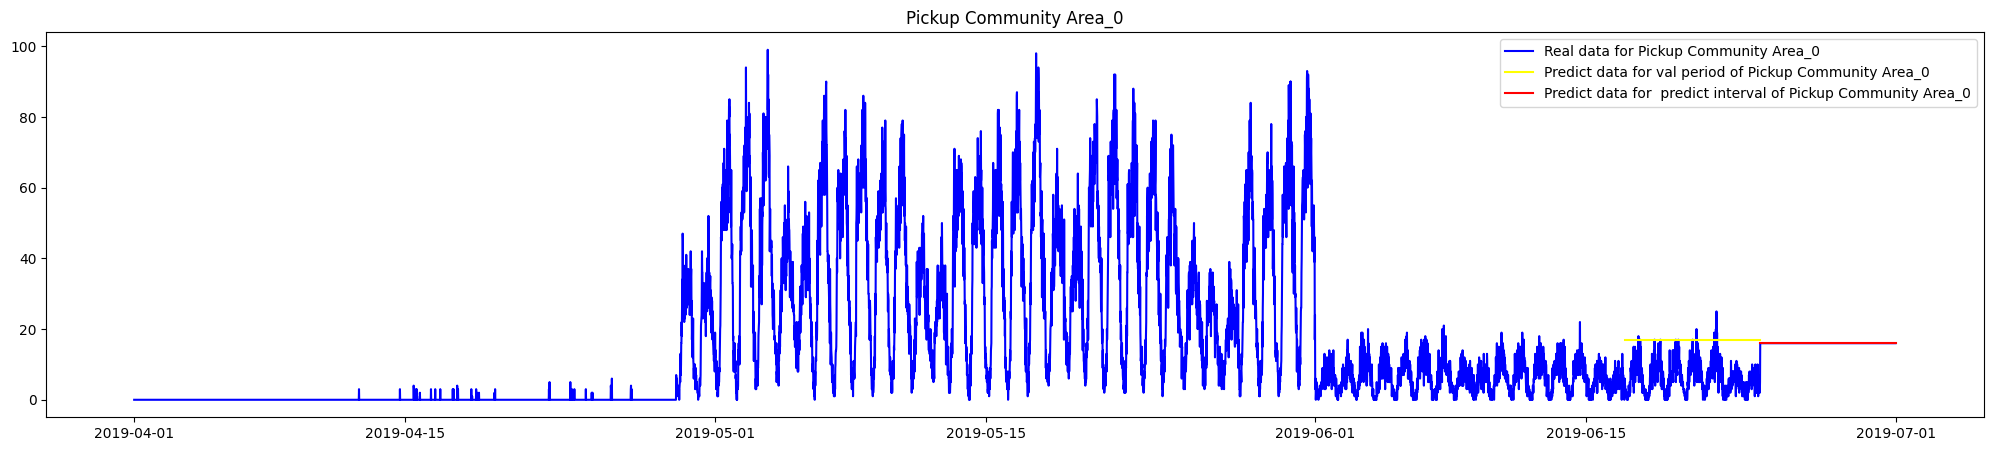

In [15]:
for area in df_total[df_total.columns[:1]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_naive_average_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [16]:
df_naive_average_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-30 22:45:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:00:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:15:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:30:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:45:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0


In [17]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

3.054258241758242

In [18]:
df_results.loc[ len(df_results.index )] = ['Naive averages', round(res_mae, 2)]

## Moving averages

1. For each area make a prediction with different moving averages for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for the validation dataset.
---
1. Для каждой области сделать прогноз с разными скользящими средними для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

https://habr.com/ru/companies/otus/articles/728118/

Посчитаем скользящие средние значения для разных окон, от получаса до месяца ([2, 4, 96, 672, 2880]) по каждой области (т.е. столбцу) датафрейма df. Это будут предсказания на следующую неделю

In [19]:
df_moving_average_2_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										  parse_dates=True)
df_moving_average_4_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										  parse_dates=True)
df_moving_average_96_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										   parse_dates=True)
df_moving_average_672_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
											 parse_dates=True)
df_moving_average_2880_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
											 parse_dates=True)

df_dict = {2: df_moving_average_2_predict,
		   4: df_moving_average_4_predict,
		   96: df_moving_average_96_predict,
		   672: df_moving_average_672_predict,
		   2880: df_moving_average_2880_predict}

In [20]:
for window in [2, 4, 96, 672, 2880]:
		print(f'MeanAbsoluteError for moving average with window = {window}:')
		df_val_predict = df.rolling(window, min_periods=1).mean()
		res_mae = mean_absolute_error(df_val, df_val_predict[-672:])
		print(res_mae)
		if window in [2, 4, 96]:
			df_results.loc[ len(df_results.index )] = [f'* Moving averages with window {window}', round(res_mae, 2)]
		else:
			df_results.loc[ len(df_results.index )] = [f'Moving averages with window {window}', round(res_mae, 2)]
		# plt.figure(figsize=(25,5))
		# plt.plot(df[area], label=f'Real data for {area}', color='blue')
		# plt.plot(df_val_predict[area][-672:], label=f'Predict data for val period of  {area}', color='yellow')
		# plt.plot(df_dict[window][area][-672:], label=f'Predict data for predict period for {area}', color='red')

MeanAbsoluteError for moving average with window = 2:
0.20109317765567766
MeanAbsoluteError for moving average with window = 4:
0.26902567918192916
MeanAbsoluteError for moving average with window = 96:
0.6271985573743386
MeanAbsoluteError for moving average with window = 672:
0.6496883676013139
MeanAbsoluteError for moving average with window = 2880:
1.9485606401459261


In [21]:
for window in [2, 4, 96, 672, 2880]:
	df_dict[window].fillna(0.0, inplace=True)

In [22]:
df_moving_average_4_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# for area in df:
#     for window in [2, 4, 96, 672, 2880]:
#         df_dict[window][area] = df[area].rolling(window).mean()

for window in [2, 4, 96, 672, 2880]:
	df_dict[window] = df_total.rolling(window, min_periods=1).mean()
	df_dict[window] = update_df(df_dict[window])

In [24]:
# df_naive_average_predict = update_df(df_naive_average_predict)
# df_val_predict = update_df(df_val_predict)

In [25]:
df_moving_average_4_predict.head(700)

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Predict for moving average with window = 2:


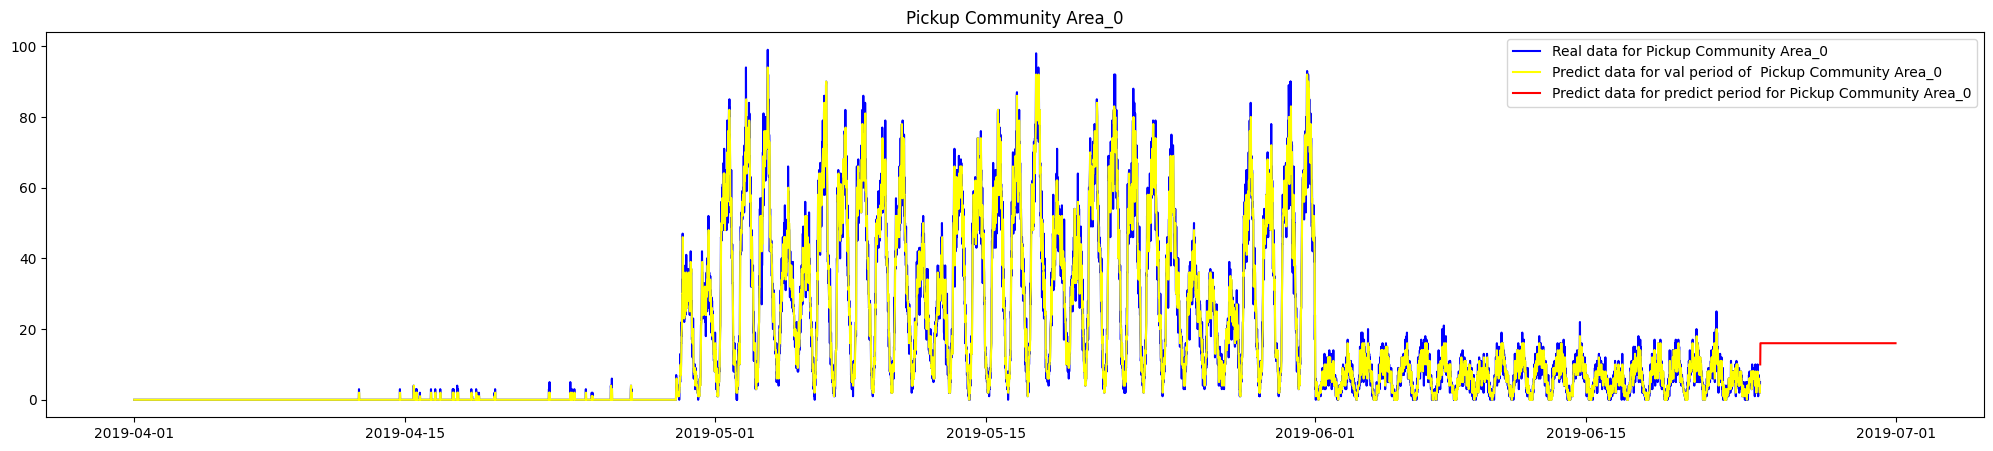

Predict for moving average with window = 4:


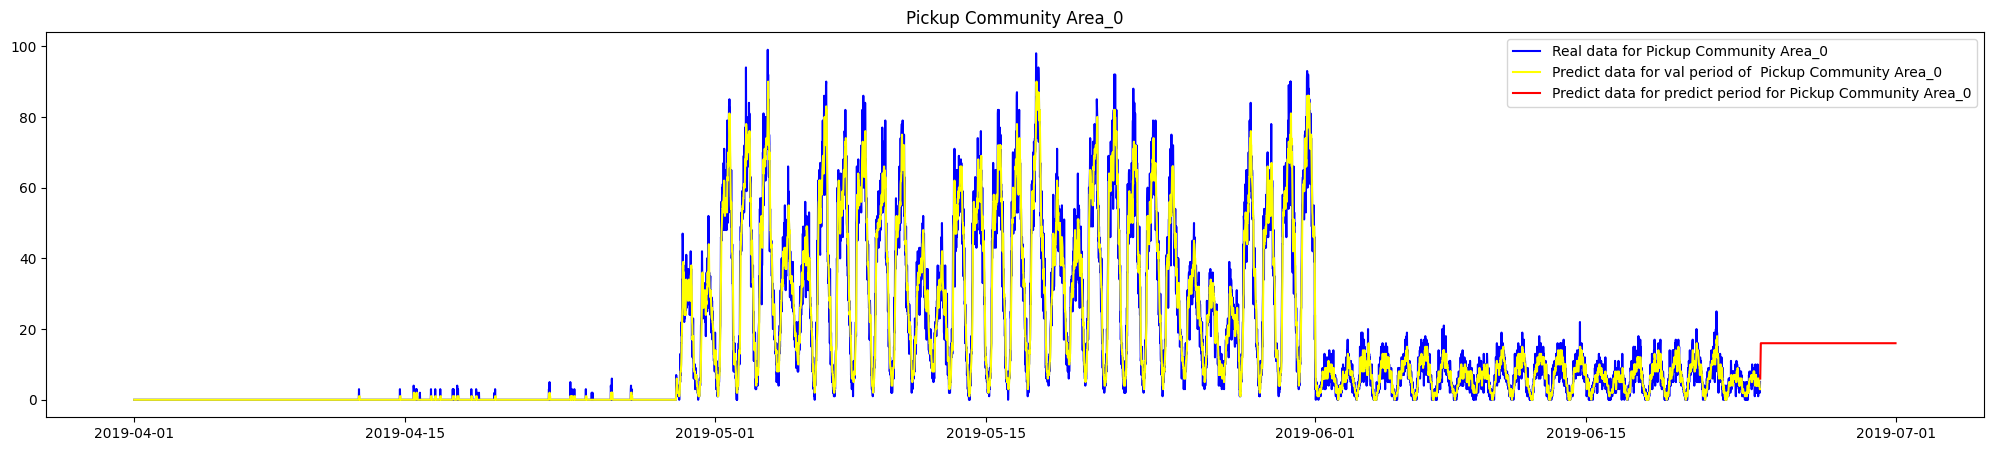

Predict for moving average with window = 96:


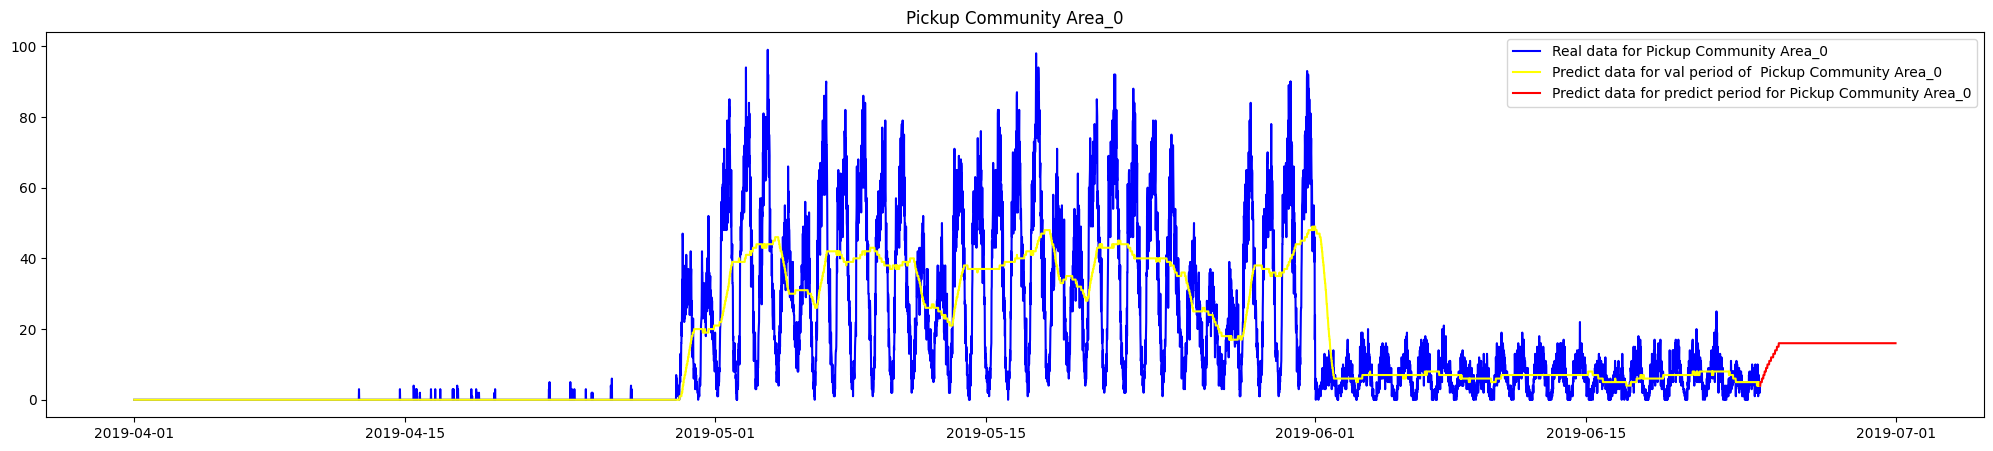

Predict for moving average with window = 672:


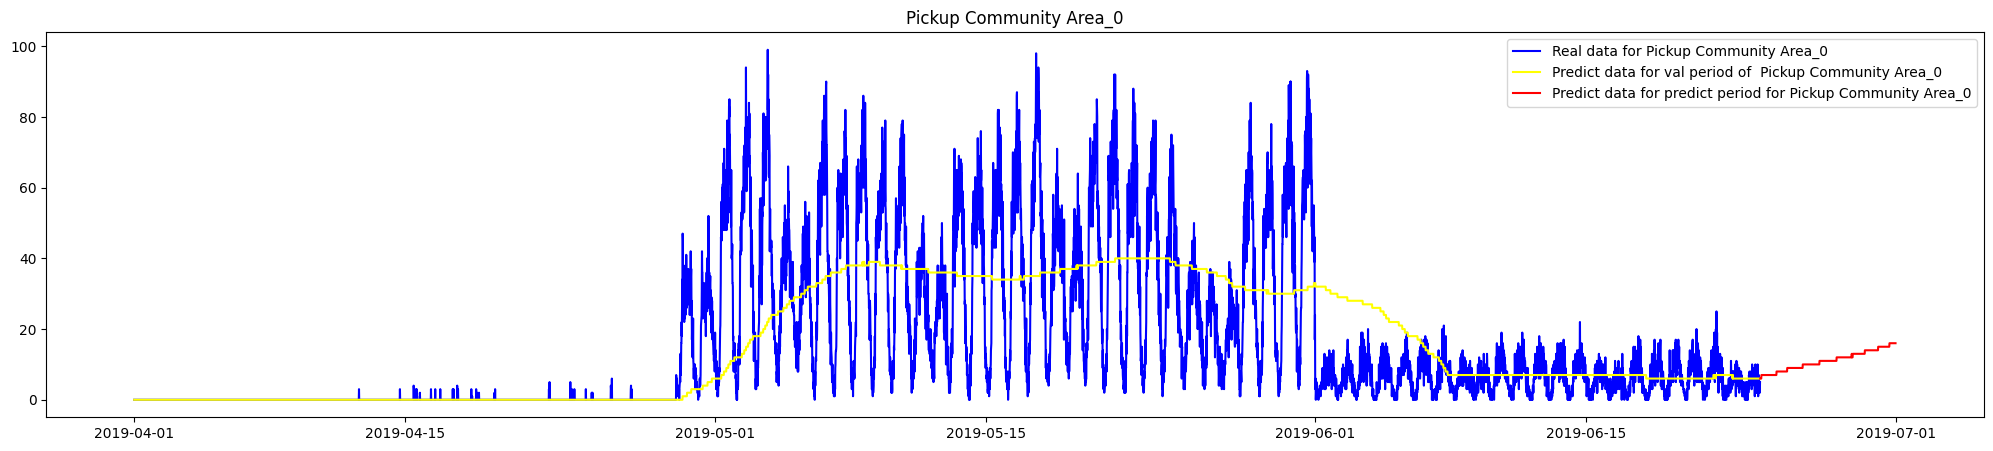

Predict for moving average with window = 2880:


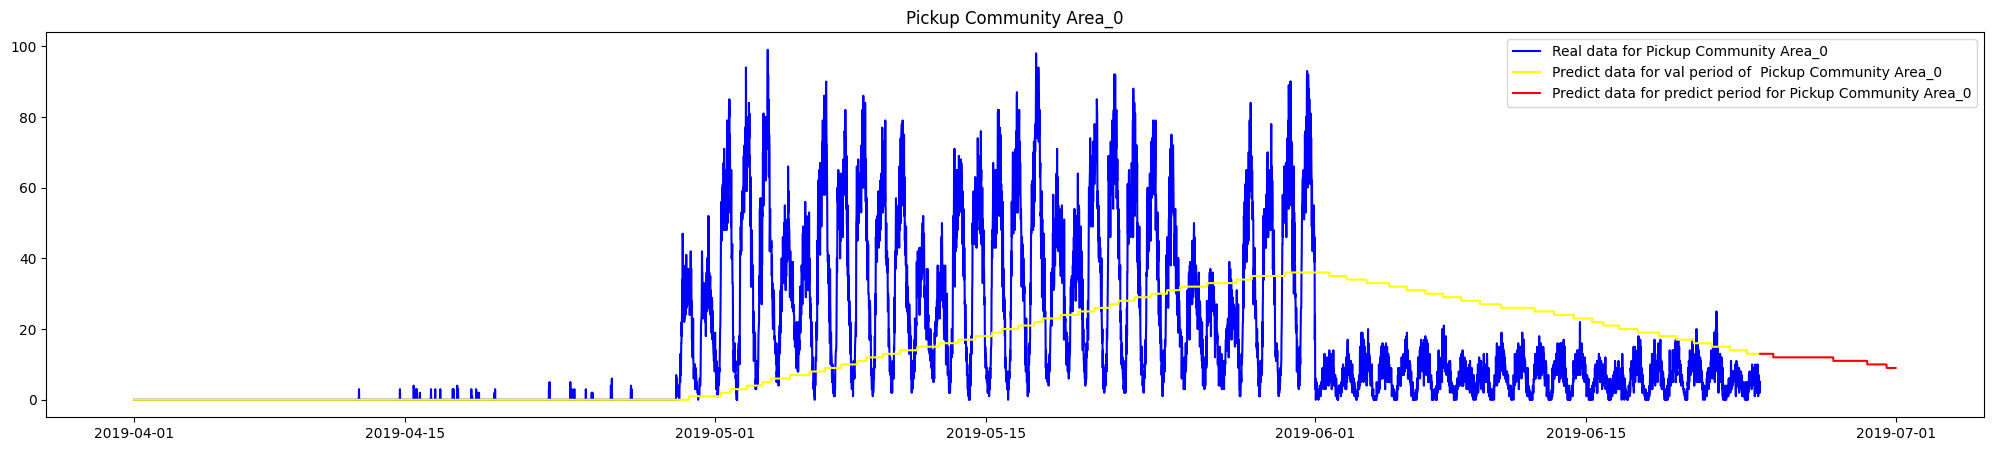

In [26]:
for area in df[df.columns[:1]]:
	for window in [2, 4, 96, 672, 2880]:
		print(f'Predict for moving average with window = {window}:')
		df_val_predict = df.rolling(window, min_periods=1).mean()
		df_val_predict = update_df(df_val_predict)
		plt.figure(figsize=(25,5))
		plt.plot(df[area], label=f'Real data for {area}', color='blue')
		plt.plot(df_val_predict[area], label=f'Predict data for val period of  {area}', color='yellow')
		plt.plot(df_dict[window][area][-672:], label=f'Predict data for predict period for {area}', color='red')
		plt.legend(loc='best')
		plt.title(area)
		plt.show()

## Exponential smoothing

1. For each area make a prediction with 3 different exponential smoothing algorithms for this area for the next 673 intervals. Optimize the weights.
2. Calculate mean absolute error (MAE) for the validation dataset.


1. Для каждой области сделать прогноз с помощью 3 различных алгоритмов экспоненциального сглаживания для этой области на следующие 673 интервала. Оптимизируйте веса.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

Разложим временной ряд и посмотрим, есть ли в данных уровни, тренды и сезонность. Период - 15 минут (4*24).

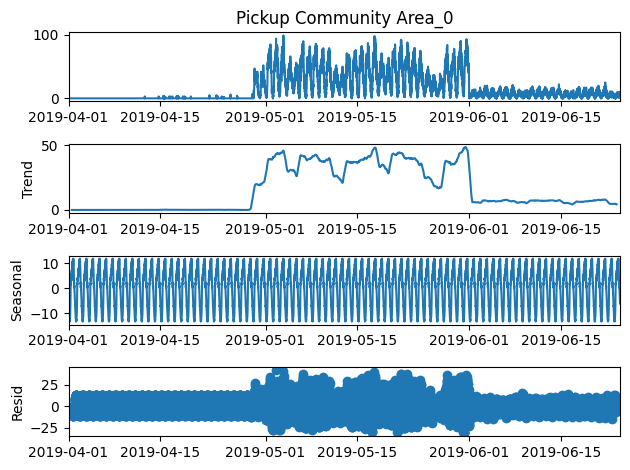

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

for area in df_total[df_total.columns[:1]]:
	decompose_result = seasonal_decompose(df[area], period = 4*24, model='additive')
	decompose_result.plot()

In [28]:
df_val = df['2019-06-17':'2019-06-23'].copy()
df_val_predict = df_val.copy() * 0.0
# df_val = df.copy()
# df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model = SimpleExpSmoothing(np.asarray(df_train[area])).fit(smoothing_level=0.2, optimized=False, use_brute=True)
	# df_val_predict[area] = model.fittedvalues[:672]
	df_val_predict[area] = model.forecast(672)

In [29]:
df_braun_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_braun_predict.fillna(0.0, inplace=True)

for area in df_train:
	model = SimpleExpSmoothing(np.asarray(df[area])).fit(smoothing_level=0.2, optimized=False, use_brute=True)
	df_braun_predict[area] = model.forecast(672)
	# df_braun_predict[area] = model.fittedvalues[:672]

In [30]:
df_braun_predict = update_df(df_braun_predict)
df_val_predict = update_df(df_val_predict)

In [31]:
df_total = df.copy()
df_total = df_total.append(df_braun_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/4151968948.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_braun_predict)


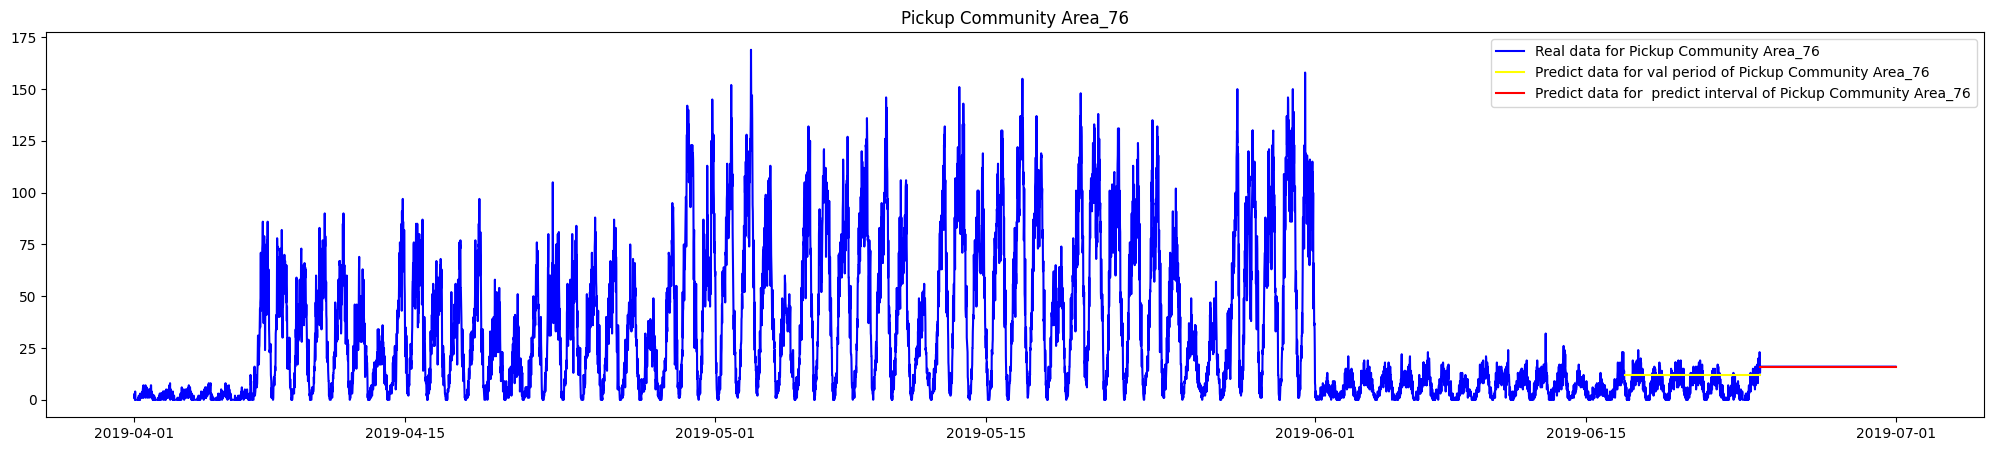

In [32]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_braun_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [33]:
# df_val = df.copy()
res_mae = round(mean_absolute_error(df_val, df_val_predict), 2)
res_mae

0.72

In [34]:
df_results.loc[ len(df_results.index )] = ['Simple Exponential Smoothing (Braun)', round(res_mae, 2)]

In [35]:
df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model = Holt(np.asarray(df_train[area])).fit(smoothing_level=0.2, smoothing_trend=0.00045, optimized=False, use_brute=True)
	df_val_predict[area] = model.forecast(672)
	# df_val_predict[area] = model.fittedvalues[:672]

In [36]:
df_holt_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_holt_predict.fillna(0.0, inplace=True)

for area in df_train:
	model = Holt(np.asarray(df[area])).fit(smoothing_level=0.2, smoothing_trend=0.00045, optimized=False, use_brute=True)
	df_holt_predict[area] = model.forecast(672)
	# df_holt_predict[area] = model.fittedvalues[:672]

In [37]:
df_holt_predict = update_df(df_holt_predict)
df_val_predict = update_df(df_val_predict)

In [38]:
df_total = df.copy()
df_total = df_total.append(df_holt_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/2067574991.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_holt_predict)


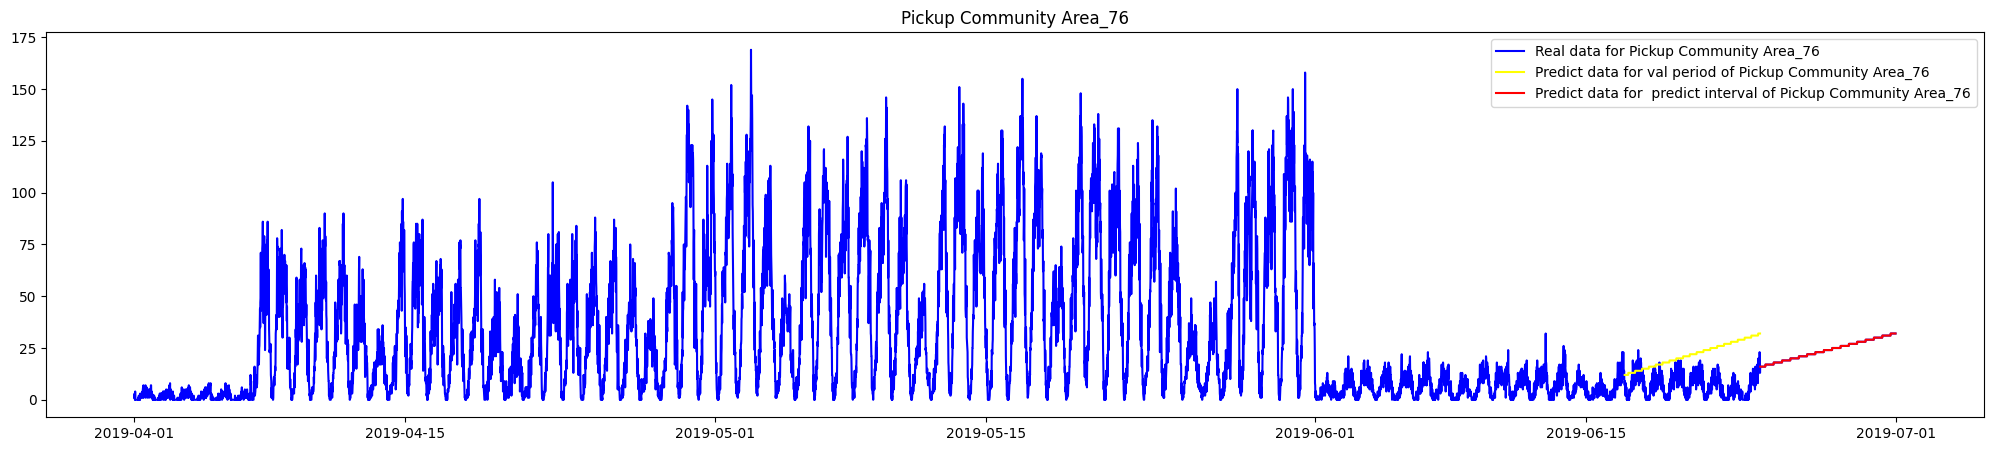

In [39]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_holt_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [40]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.8582684676434678

In [41]:
df_results.loc[ len(df_results.index )] = ['Exponential Smoothing (Holt)', round(res_mae, 2)]

In [42]:
df_holt_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:15:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:30:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:45:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 01:00:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0


In [43]:
from scipy.special import lmbda

df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model_es = ExponentialSmoothing(np.asarray(df_train[area]),
											seasonal_periods=4*12,
											trend="add",
											seasonal="add",
											damped_trend=True,
											use_boxcox=1.01,
											initialization_method="estimated")
		# .fit(use_brute=True, smoothing_level=0.2, smoothing_trend=0.00045, smoothing_seasonal=0.35)
	res = model_es.fit(use_brute=True, smoothing_level=0.2, smoothing_trend=0.00045, smoothing_seasonal=0.35)
	df_val_predict[area] = res.forecast(672)

In [44]:
df_val_predict['Pickup Community Area_76']

Trip Start Timestamp
2019-06-17 00:00:00     8.812324
2019-06-17 00:15:00     9.745632
2019-06-17 00:30:00    11.949386
2019-06-17 00:45:00    10.154624
2019-06-17 01:00:00     9.285426
                         ...    
2019-06-23 22:45:00     9.520282
2019-06-23 23:00:00    11.102838
2019-06-23 23:15:00    12.766293
2019-06-23 23:30:00    11.387675
2019-06-23 23:45:00    10.181954
Name: Pickup Community Area_76, Length: 672, dtype: float64

In [45]:
df_val['Pickup Community Area_76']

Trip Start Timestamp
2019-06-17 00:00:00     7.0
2019-06-17 00:15:00     9.0
2019-06-17 00:30:00     5.0
2019-06-17 00:45:00     2.0
2019-06-17 01:00:00     2.0
                       ... 
2019-06-23 22:45:00    14.0
2019-06-23 23:00:00    14.0
2019-06-23 23:15:00    23.0
2019-06-23 23:30:00    19.0
2019-06-23 23:45:00    13.0
Name: Pickup Community Area_76, Length: 672, dtype: float64

In [46]:
df_holt_winters_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_holt_winters_predict.fillna(0.0, inplace=True)

for area in df:
	model_es = ExponentialSmoothing(np.asarray(df[area]),
											seasonal_periods=4*12,
											trend="add",
											seasonal="add",
											damped_trend=True,
											use_boxcox=1.01,
											initialization_method="estimated").fit(use_brute=True, smoothing_level=0.2, smoothing_trend=0.00045, smoothing_seasonal=0.35)
	df_holt_winters_predict[area] = model_es.forecast(672)

In [47]:
df_val_predict = df_val_predict.fillna(0)
df_holt_winters_predict = df_holt_winters_predict.fillna(0)

df_holt_winters_predict = update_df(df_holt_winters_predict)
df_val_predict = update_df(df_val_predict)

In [48]:
df_total = df.copy()
df_total = df_total.append(df_holt_winters_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/2217355837.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_holt_winters_predict)


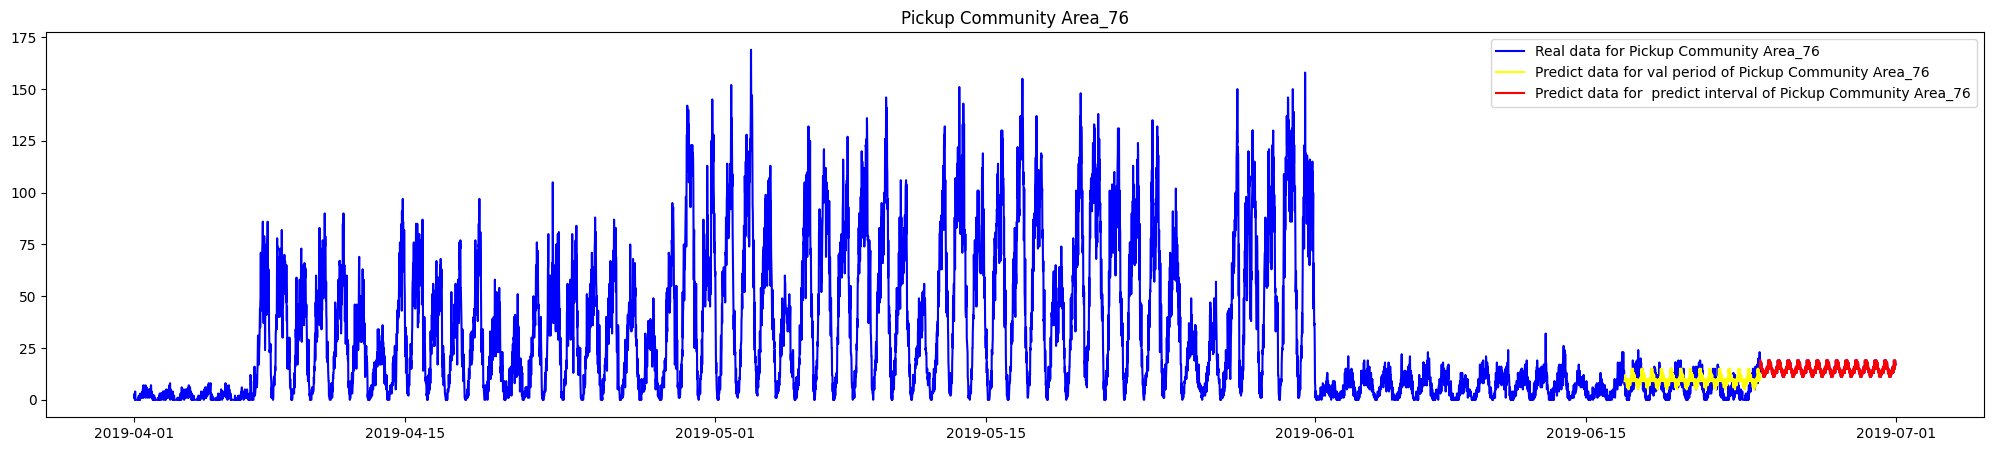

In [49]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_holt_winters_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [50]:
df_val_predict = df_val_predict.fillna(0)
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.7658348595848594

In [51]:
df_results.loc[ len(df_results.index )] = ['Exponential Smoothing (Holt-Winters)', round(res_mae, 2)]

## ARIMA

1. For each area make a prediction with the best SARIMA model according to AIC metrics for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for the validation dataset.


1. Для каждой области сделать прогноз с помощью лучшей модели SARIMA по метрикам AIC для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

Определим с помощью теста Дики-Фуллера (Dickey-Fuller test) являются ли ряды по каждой из областей стационарными. Подробнее - https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0 и https://www.codecamp.ru/blog/dickey-fuller-test-python/

In [52]:
import statsmodels.api as sm

n = 0
for area in df_train:
	p = sm.tsa.stattools.adfuller(df_train[area])[1]
	if p > 0.05:
		print(f'Ряд по области {area} не является стационарным. По критерию Дики-Фуллера p-value = {p}')
if n == 0:
	print(f'Ряды по всем областям являются стационарными. По критерию Дики-Фуллера p-value <= 0.05')

Ряды по всем областям являются стационарными. По критерию Дики-Фуллера p-value <= 0.05


In [53]:
gc.collect()

33247

In [54]:
model_s = pm.auto_arima(df_train['Pickup Community Area_76'],
						# start_p=0, start_q=0,
						test='adf',
						# max_p=2, max_q=2,
						m=4,
						# start_P=0, start_Q=0,
						seasonal=True,
						d=0, D=0,
						trace=True,
						error_action='ignore',
						# information_criterion='bic',
						suppress_warnings=True,
						scoring='mae',
						stepwise=True)

model_s.summary()




Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=54444.075, Time=9.14 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=73311.206, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=55239.509, Time=2.20 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=62026.730, Time=2.24 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=78004.666, Time=0.06 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=54458.784, Time=5.41 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=54444.475, Time=6.48 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=54448.474, Time=9.99 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=54462.032, Time=10.35 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=54615.604, Time=4.93 sec
 ARIMA(2,0,2)(0,0,2)[4] intercept   : AIC=54441.650, Time=10.34 sec
 ARIMA(1,0,2)(0,0,2)[4] intercept   : AIC=54447.049, Time=2.63 sec
 ARIMA(2,0,1)(0,0,2)[4] intercept   : AIC=54447.320, Time=5.43 sec
 ARIMA(3,0,2)(0,0,2)[4] intercept   : AIC=54445.858, Time=5.55 sec
 ARIMA(2,0,3)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 7392
Model:             SARIMAX(2, 0, 3)x(0, 0, [1], 4)   Log Likelihood              -27167.706
Date:                             Thu, 04 May 2023   AIC                          54351.412
Time:                                     03:54:56   BIC                          54406.677
Sample:                                 04-01-2019   HQIC                         54370.403
                                      - 06-16-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1015      0.023      4.349      0.000       0.056       0.147
ar.L1          1.9237      0.015    125.587      0.000       1.894       1.954
ar.L2         -0.9269      0.015    -62.048      0.000      -0.956      -0.898
ma.L1         -1.3139      0.017    -76.589      0.000      -1.347      -1.280
ma.L2          0.3157      0.015     21.241      0.000       0.287       0.345
ma.L3          0.0631      0.009      6.906      0.000       0.045       0.081
ma.S.L4        0.1118      0.009     12.591      0.000       0.094       0.129
sigma2        91.3401      0.943     96.848      0.000      89.492      93.189
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3615.47
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

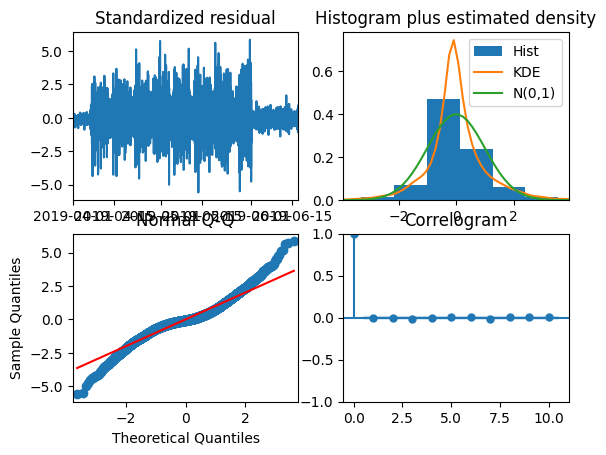

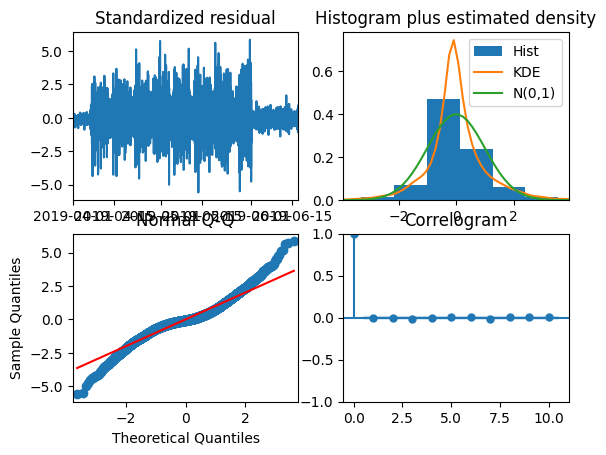

In [55]:
model_s.plot_diagnostics()

In [56]:
prediction = model_s.predict(n_periods=672, dynamic=True)

In [57]:
prediction

2019-06-17 00:00:00     9.975073
2019-06-17 00:15:00    10.549870
2019-06-17 00:30:00    10.482723
2019-06-17 00:45:00    10.733235
2019-06-17 01:00:00    11.335239
                         ...    
2019-06-23 22:45:00    32.450810
2019-06-23 23:00:00    32.450810
2019-06-23 23:15:00    32.450810
2019-06-23 23:30:00    32.450810
2019-06-23 23:45:00    32.450810
Freq: 15T, Length: 672, dtype: float64

In [58]:
df_val_predict = df_val.copy() * 0.0
for area in df_train:

	model_arima = SARIMAX(np.asarray(df_train[area]), order=(2, 0, 3), seasonal_order=(0, 0, 1, 4))
	sarima_ = model_arima.fit()
	# df_val_predict[area] = result.predict(len(df[area])-671,len(df_train[area]))
	df_val_predict[area] = sarima_.get_prediction(start=len(df_train[area]), end=len(df_train[area]) + 671).predicted_mean
	# df_val_predict[area] = result.forecast(672)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34672D+00    |proj g|=  8.17412D-01

At iterate    5    f=  3.04634D+00    |proj g|=  6.91336D-03

At iterate   10    f=  3.04455D+00    |proj g|=  1.08018D-02

At iterate   15    f=  3.04324D+00    |proj g|=  7.93341D-04

At iterate   20    f=  3.04305D+00    |proj g|=  7.78370D-03

At iterate   25    f=  3.03786D+00    |proj g|=  2.24131D-02

At iterate   30    f=  3.03710D+00    |proj g|=  3.41049D-03

At iterate   35    f=  3.03709D+00    |proj g|=  1.12651D-04

At iterate   40    f=  3.03709D+00    |proj g|=  3.69435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  1.64525D+00    |proj g|=  1.17110D-03

At iterate   10    f=  1.64523D+00    |proj g|=  6.70671D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     15      1     0     0   9.571D-06   1.645D+00
  F =   1.6452302606510196     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64580D+00    |proj g|=  1.66722D-01

At iterate    5    f=  1.63137D+00    |proj g|=  1.59332D-03

At iterate   10    f=  1.63090D+00    |proj g|=  1.14159D-02

At iterate   15    f=  1.63077D+00    |proj g|=  1.42201D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     20      1     0     0   1.485D-05   1.631D+00
  F =   1.6307737612407611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  2.07648D+00    |proj g|=  1.19684D-03

At iterate   10    f=  2.07644D+00    |proj g|=  4.79451D-03

At iterate   15    f=  2.07641D+00    |proj g|=  1.38940D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     18      1     0     0   7.111D-06   2.076D+00
  F =   2.0764113689536687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46130D+00    |proj g|=  1.64798D-01

At iterate    5    f=  1.44671D+00    |proj g|=  1.67220D-03

At iterate   10    f=  1.44669D+00    |proj g|=  1.76156D-03

At iterate   15    f=  1.44663D+00    |proj g|=  1.24788D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   1.146D-05   1.447D+00
  F =   1.4466296821457307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22176D+00    |proj g|=  1.30470D-01

At iterate    5    f=  1.21036D+00    |proj g|=  4.13006D-03

At iterate   10    f=  1.21023D+00    |proj g|=  5.48934D-04

At iterate   15    f=  1.21006D+00    |proj g|=  1.51325D-02

At iterate   20    f=  1.20981D+00    |proj g|=  6.36805D-04

At iterate   25    f=  1.20981D+00    |proj g|=  1.12301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     28      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  2.90991D+00    |proj g|=  5.91582D-02

At iterate   10    f=  2.90453D+00    |proj g|=  6.54023D-03

At iterate   15    f=  2.90424D+00    |proj g|=  2.91074D-03

At iterate   20    f=  2.90422D+00    |proj g|=  1.18669D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     23      1     0     0   1.187D-05   2.904D+00
  F =   2.9042211567003271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.46986D+00    |proj g|=  3.25331D-03

At iterate   10    f=  2.46974D+00    |proj g|=  5.36123D-03

At iterate   15    f=  2.46967D+00    |proj g|=  2.22004D-04

At iterate   20    f=  2.46966D+00    |proj g|=  3.49936D-03

At iterate   25    f=  2.46903D+00    |proj g|=  9.84826D-03

At iterate   30    f=  2.46872D+00    |proj g|=  9.76473D-04

At iterate   35    f=  2.46872D+00    |proj g|=  8.24444D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     42      1     0     0   3.297D-05   2.469D+00
  F =   2.4687191301829809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.47412D+00    |proj g|=  2.26613D+00

At iterate   10    f=  5.05768D+00    |proj g|=  5.41495D-01

At iterate   15    f=  4.23548D+00    |proj g|=  2.60465D-01

At iterate   20    f=  4.14690D+00    |proj g|=  2.95474D-02

At iterate   25    f=  4.13817D+00    |proj g|=  4.14668D-02

At iterate   30    f=  4.12988D+00    |proj g|=  9.90982D-03

At iterate   35    f=  4.12831D+00    |proj g|=  1.19905D-03

At iterate   40    f=  4.12830D+00    |proj g|=  1.77868D-03

At iterate   45    f=  4.12790D+00    |proj g|=  7.38234D-03

At iterate   50    f=  4.12737D+00    |proj g|=  1.20962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.09993D-01    |proj g|=  5.84138D-02

At iterate    5    f= -6.10477D-01    |proj g|=  7.18227D-03

At iterate   10    f= -6.10643D-01    |proj g|=  1.16161D-01

At iterate   15    f= -6.10757D-01    |proj g|=  1.77923D-02

At iterate   20    f= -6.10889D-01    |proj g|=  3.05352D-02

At iterate   25    f= -6.10997D-01    |proj g|=  4.52813D-03

At iterate   30    f= -6.11223D-01    |proj g|=  1.35705D-02

At iterate   35    f= -6.14518D-01    |proj g|=  3.10064D-02

At iterate   40    f= -6.14805D-01    |proj g|=  1.09158D-03

At iterate   45    f= -6.14814D-01    |proj g|=  1.25329D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



At iterate   50    f= -6.14836D-01    |proj g|=  6.22845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   6.228D-03  -6.148D-01
  F = -0.61483647842600553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45918D+01    |proj g|=  5.32338D+01

At iterate    5    f=  7.98984D-01    |proj g|=  1.46694D-01

At iterate   10    f=  7.73846D-01    |proj g|=  4.26083D-02

At iterate   15    f=  7.53993D-01    |proj g|=  5.22914D-03

At iterate   20    f=  7.53912D-01    |proj g|=  6.63804D-04

At iterate   25    f=  7.53905D-01    |proj g|=  9.74703D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     32      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27210D+00    |proj g|=  1.53976D-01

At iterate    5    f=  1.25741D+00    |proj g|=  5.31172D-03

At iterate   10    f=  1.25737D+00    |proj g|=  4.64843D-04

At iterate   15    f=  1.25735D+00    |proj g|=  3.63598D-04

At iterate   20    f=  1.25735D+00    |proj g|=  2.80758D-05

At iterate   25    f=  1.25735D+00    |proj g|=  1.33348D-03

At iterate   30    f=  1.25733D+00    |proj g|=  9.54283D-04

At iterate   35    f=  1.25731D+00    |proj g|=  8.61123D-04

At iterate   40    f=  1.25731D+00    |proj g|=  1.29175D-04

At iterate   45    f=  1.25731D+00    |proj g|=  2.81605D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  3.89153D-01    |proj g|=  4.11471D-02

At iterate   10    f=  3.87974D-01    |proj g|=  1.15139D-02

At iterate   15    f=  3.87400D-01    |proj g|=  1.41850D-02

At iterate   20    f=  3.86924D-01    |proj g|=  7.71918D-04

At iterate   25    f=  3.86924D-01    |proj g|=  6.79523D-05

At iterate   30    f=  3.86921D-01    |proj g|=  2.93292D-03

At iterate   35    f=  3.86873D-01    |proj g|=  7.29746D-03

At iterate   40    f=  3.86844D-01    |proj g|=  9.56404D-04

At iterate   45    f=  3.86781D-01    |proj g|=  3.78911D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



At iterate   50    f=  3.86717D-01    |proj g|=  1.47263D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.473D-02   3.867D-01
  F =  0.38671689333897130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14253D-01    |proj g|=  4.33588D-01

At iterate    5    f=  8.36430D-01    |proj g|=  2.26518D-02

At iterate   10    f=  8.11109D-01    |proj g|=  1.02176D-01

At iterate   15    f=  7.86666D-01    |proj g|=  1.60763D-01

At iterate   20    f=  7.84640D-01    |proj g|=  8.55423D-04

At iterate   25    f=  7.84628D-01    |proj g|=  1.09325D-04

At iterate   30    f=  7.84627D-01    |proj g|=  3.75658D-04

At iterate   35    f=  7.84620D-01    |proj g|=  4.20304D-03

At iterate   40    f=  7.84578D-01    |proj g|=  5.72552D-03

At iterate   45    f=  7.84544D-01    |proj g|=  3.34559D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.84514D-01    |proj g|=  2.17256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.173D-03   7.845D-01
  F =  0.78451426459581552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22332D+00    |proj g|=  1.31962D-01


 This problem is unconstrained.



At iterate    5    f=  1.21225D+00    |proj g|=  8.84941D-03

At iterate   10    f=  1.21188D+00    |proj g|=  3.98143D-04

At iterate   15    f=  1.21172D+00    |proj g|=  8.01410D-03

At iterate   20    f=  1.21137D+00    |proj g|=  1.71181D-03

At iterate   25    f=  1.21137D+00    |proj g|=  2.04410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     35      1     0     0   8.538D-06   1.211D+00
  F =   1.2113686941521977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08570D+00    |proj g|=  1.34739D-01

At iterate    5    f=  1.07452D+00    |proj g|=  8.02849D-03

At iterate   10    f=  1.07426D+00    |proj g|=  3.98066D-04

At iterate   15    f=  1.07425D+00    |proj g|=  2.02910D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   2.362D-05   1.074D+00
  F =   1.0742529954059929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47383D+00    |proj g|=  1.67039D-01

At iterate    5    f=  1.45330D+00    |proj g|=  1.64768D-02

At iterate   10    f=  1.45236D+00    |proj g|=  7.99458D-03

At iterate   15    f=  1.45167D+00    |proj g|=  1.70914D-04

At iterate   20    f=  1.45167D+00    |proj g|=  1.68894D-04

At iterate   25    f=  1.45167D+00    |proj g|=  4.77745D-05

At iterate   30    f=  1.45167D+00    |proj g|=  3.50378D-04

At iterate   35    f=  1.45166D+00    |proj g|=  7.17625D-04

At iterate   40    f=  1.45165D+00    |proj g|=  2.27266D-03

At iterate   45    f=  1.45164D+00    |proj g|=  5.29199D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.45162D+00    |proj g|=  7.47086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   7.471D-04   1.452D+00
  F =   1.4516249389705900     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02968D+01    |proj g|=  1.17772D+02

At iterate    5    f=  3.67998D-01    |proj g|=  2.49635D-01

At iterate   10    f=  3.34057D-01    |proj g|=  1.29554D-02

At iterate   15    f=  3.26484D-01    |proj g|=  8.81676D-02

At iterate   20    f=  3.22754D-01    |proj g|=  1.19676D-02

At iterate   25    f=  3.22676D-01    |proj g|=  2.20527D-03

At iterate   30    f=  3.22610D-01    |proj g|=  2.31337D-03

At iterate   35    f=  3.22609D-01    |proj g|=  3.41581D-03

At iterate   40    f=  3.22582D-01    |proj g|=  3.15276D-03

At iterate   45    f=  3.22557D-01    |proj g|=  8.27241D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47262D+01    |proj g|=  1.77749D+02

At iterate    5    f= -2.99848D-01    |proj g|=  1.96874D-01

At iterate   10    f= -3.59577D-01    |proj g|=  2.66657D-02

At iterate   15    f= -3.60676D-01    |proj g|=  8.08059D-03

At iterate   20    f= -3.65832D-01    |proj g|=  1.25257D-01

At iterate   25    f= -3.67411D-01    |proj g|=  2.32022D-03

At iterate   30    f= -3.67433D-01    |proj g|=  2.07497D-02

At iterate   35    f= -3.67438D-01    |proj g|=  5.84417D-04

At iterate   40    f= -3.67440D-01    |proj g|=  9.17419D-04

At iterate   45    f= -3.67454D-01    |proj g|=  2.99793D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.67454D-01    |proj g|=  1.03761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.038D-04  -3.675D-01
  F = -0.36745425001424736     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94858D-01    |proj g|=  9.81413D-02

At iterate    5    f=  4.87293D-01    |proj g|=  5.40172D-02

At iterate   10    f=  4.83520D-01    |proj g|=  1.38062D-02

At iterate   15    f=  4.82060D-01    |proj g|=  1.97038D-02

At iterate   20    f=  4.79545D-01    |proj g|=  2.21073D-02

At iterate   25    f=  4.77592D-01    |proj g|=  4.32900D-03

At iterate   30    f=  4.77417D-01    |proj g|=  1.21704D-03

At iterate   35    f=  4.77413D-01    |proj g|=  6.81370D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81748D-02    |proj g|=  1.87022D-01

At iterate    5    f=  8.67914D-02    |proj g|=  1.07377D-02

At iterate   10    f=  8.67129D-02    |proj g|=  7.18993D-03

At iterate   15    f=  8.61956D-02    |proj g|=  1.16011D-01

At iterate   20    f=  7.38878D-02    |proj g|=  7.05358D-02

At iterate   25    f=  5.86087D-02    |proj g|=  4.83947D-02

At iterate   30    f=  5.64013D-02    |proj g|=  1.05132D-03

At iterate   35    f=  5.62335D-02    |proj g|=  1.23560D-02

At iterate   40    f=  5.61343D-02    |proj g|=  5.26488D-04

At iterate   45    f=  5.61070D-02    |proj g|=  1.04579D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.60738D-02    |proj g|=  1.25017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.250D-04   5.607D-02
  F =   5.6073806296188237E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32065D+00    |proj g|=  1.75906D-01

At iterate    5    f=  1.30306D+00    |proj g|=  4.30854D-03

At iterate   10    f=  1.30281D+00    |proj g|=  6.38789D-03

At iterate   15    f=  1.30278D+00    |proj g|=  6.47466D-05

At iterate   20    f=  1.30278D+00    |proj g|=  1.85217D-03

At iterate   25    f=  1.30275D+00    |proj g|=  7.85580D-04

At iterate   30    f=  1.30274D+00    |proj g|=  3.46122D-04

At iterate   35    f=  1.30273D+00    |proj g|=  7.19883D-04

At iterate   40    f=  1.30271D+00    |proj g|=  1.59604D-03

At iterate   45    f=  1.30270D+00    |proj g|=  1.48320D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.30264D+00    |proj g|=  2.84164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   2.842D-03   1.303D+00
  F =   1.3026371506033756     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58351D+00    |proj g|=  2.40110D-01

At iterate    5    f=  1.55382D+00    |proj g|=  1.15429D-02

At iterate   10    f=  1.55351D+00    |proj g|=  1.09814D-02

At iterate   15    f=  1.55317D+00    |proj g|=  2.79483D-04

At iterate   20    f=  1.55316D+00    |proj g|=  3.12305D-03

At iterate   25    f=  1.55301D+00    |proj g|=  2.04975D-03

At iterate   30    f=  1.55301D+00    |proj g|=  7.34934D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05130D+01    |proj g|=  4.30764D+01

At iterate    5    f=  6.68600D-01    |proj g|=  1.30864D-01

At iterate   10    f=  6.42006D-01    |proj g|=  4.67723D-02

At iterate   15    f=  6.20211D-01    |proj g|=  2.25708D-02

At iterate   20    f=  6.17814D-01    |proj g|=  6.27203D-03

At iterate   25    f=  6.17747D-01    |proj g|=  1.00505D-02

At iterate   30    f=  6.17696D-01    |proj g|=  4.40659D-04

At iterate   35    f=  6.17695D-01    |proj g|=  7.61298D-04

At iterate   40    f=  6.17689D-01    |proj g|=  2.01667D-03

At iterate   45    f=  6.17688D-01    |proj g|=  5.38530D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  2.20085D+00    |proj g|=  8.51907D-02

At iterate   10    f=  2.08656D+00    |proj g|=  5.09670D-02

At iterate   15    f=  2.08160D+00    |proj g|=  4.97750D-03

At iterate   20    f=  2.08148D+00    |proj g|=  1.51529D-04

At iterate   25    f=  2.08145D+00    |proj g|=  2.03713D-03

At iterate   30    f=  2.08129D+00    |proj g|=  1.18979D-03

At iterate   35    f=  2.08125D+00    |proj g|=  6.99831D-04

At iterate   40    f=  2.08124D+00    |proj g|=  1.36904D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     45      1     0     0   2.586D-06   2.081D+00
  F =   2.08123811038

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35640D+01    |proj g|=  5.23059D+01

At iterate    5    f=  7.43919D-01    |proj g|=  5.37857D-01

At iterate   10    f=  7.12453D-01    |proj g|=  1.71901D-02

At iterate   15    f=  6.98704D-01    |proj g|=  2.42080D-02

At iterate   20    f=  6.97476D-01    |proj g|=  2.67438D-03

At iterate   25    f=  6.97336D-01    |proj g|=  5.07796D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.81330D-01    |proj g|=  8.58224D-02

At iterate    5    f= -1.85558D-01    |proj g|=  2.33484D-02

At iterate   10    f= -1.85614D-01    |proj g|=  1.36514D-03

At iterate   15    f= -1.85625D-01    |proj g|=  1.14259D-02

At iterate   20    f= -1.86570D-01    |proj g|=  5.50650D-02

At iterate   25    f= -1.94334D-01    |proj g|=  4.14038D-02

At iterate   30    f= -1.98034D-01    |proj g|=  4.64714D-03

At iterate   35    f= -2.00475D-01    |proj g|=  7.99145D-04

At iterate   40    f= -2.00788D-01    |proj g|=  1.64354D-02

At iterate   45    f= -2.00963D-01    |proj g|=  4.05995D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.01105D-01    |proj g|=  1.12241D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.122D-03  -2.011D-01
  F = -0.20110463672748988     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21582D-01    |proj g|=  1.19791D-01

At iterate    5    f=  6.13152D-01    |proj g|=  7.97737D-03

At iterate   10    f=  6.12234D-01    |proj g|=  3.30158D-03

At iterate   15    f=  6.12119D-01    |proj g|=  2.48649D-04

At iterate   20    f=  6.12103D-01    |proj g|=  4.44192D-03

At iterate   25    f=  6.12001D-01    |proj g|=  3.00715D-03

At iterate   30    f=  6.11970D-01    |proj g|=  3.07936D-03

At iterate   35    f=  6.11944D-01    |proj g|=  2.11329D-04

At iterate   40    f=  6.11942D-01    |proj g|=  3.59054D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     67      1     0     0   5.352D-05   6.119D-01
  F =  0.61194161274498104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76462D+00    |proj g|=  2.35748D-01

At iterate    5    f=  3.73493D+00    |proj g|=  1.09131D-02

At iterate   10    f=  3.73200D+00    |proj g|=  1.40657D-03

At iterate   15    f=  3.73185D+00    |proj g|=  1.77085D-03

At iterate   20    f=  3.73156D+00    |proj g|=  6.23577D-03

At iterate   25    f=  3.73146D+00    |proj g|=  1.32589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63222D-01    |proj g|=  8.70050D-02

At iterate    5    f=  2.58538D-01    |proj g|=  4.43488D-02

At iterate   10    f=  2.57608D-01    |proj g|=  2.54210D-02

At iterate   15    f=  2.56085D-01    |proj g|=  4.24837D-03

At iterate   20    f=  2.56074D-01    |proj g|=  1.17193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   5.111D-05   2.561D-01
  F =  0.25607354812401617     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  9.92309D-02    |proj g|=  2.25948D-02

At iterate   10    f=  9.79405D-02    |proj g|=  2.82199D-03

At iterate   15    f=  9.65941D-02    |proj g|=  2.84261D-02

At iterate   20    f=  9.38297D-02    |proj g|=  5.04664D-03

At iterate   25    f=  9.36037D-02    |proj g|=  1.83608D-02

At iterate   30    f=  9.35279D-02    |proj g|=  4.25714D-03

At iterate   35    f=  9.35127D-02    |proj g|=  3.47796D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     46      1     0     0   5.180D-05   9.351D-02
  F =   9.3512677981412787E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36021D-01    |proj g|=  1.18645D-01

At iterate    5    f=  6.26514D-01    |proj g|=  3.51096D-02

At iterate   10    f=  6.25114D-01    |proj g|=  2.85704D-03

At iterate   15    f=  6.23592D-01    |proj g|=  6.23648D-03

At iterate   20    f=  6.22373D-01    |proj g|=  1.38990D-03

At iterate   25    f=  6.22362D-01    |proj g|=  1.73961D-03

At iterate   30    f=  6.22356D-01    |proj g|=  2.84436D-03

At iterate   35    f=  6.22349D-01    |proj g|=  2.86547D-03

At iterate   40    f=  6.22334D-01    |proj g|=  5.31989D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29762D+00    |proj g|=  3.21085D-01

At iterate    5    f=  4.25246D+00    |proj g|=  1.04197D-02

At iterate   10    f=  4.24920D+00    |proj g|=  3.35754D-03

At iterate   15    f=  4.24889D+00    |proj g|=  9.85531D-03

At iterate   20    f=  4.24880D+00    |proj g|=  1.25513D-03

At iterate   25    f=  4.24853D+00    |proj g|=  9.06185D-03

At iterate   30    f=  4.24828D+00    |proj g|=  8.87689D-04

At iterate   35    f=  4.24828D+00    |proj g|=  2.93939D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.96548D+00    |proj g|=  9.69519D-02

At iterate   10    f=  2.95405D+00    |proj g|=  1.22302D-02

At iterate   15    f=  2.95255D+00    |proj g|=  1.13609D-02

At iterate   20    f=  2.95242D+00    |proj g|=  2.16456D-03

At iterate   25    f=  2.95117D+00    |proj g|=  1.10444D-02

At iterate   30    f=  2.95041D+00    |proj g|=  4.16133D-03

At iterate   35    f=  2.95035D+00    |proj g|=  6.16691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     40      1     0     0   6.809D-06   2.950D+00
  F =   2.9503496351590135     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25958D+00    |proj g|=  3.87115D-01

At iterate    5    f=  1.18431D+00    |proj g|=  5.31836D-03

At iterate   10    f=  1.18415D+00    |proj g|=  3.79157D-03

At iterate   15    f=  1.18412D+00    |proj g|=  3.65320D-03

At iterate   20    f=  1.18379D+00    |proj g|=  3.86859D-03

At iterate   25    f=  1.18375D+00    |proj g|=  2.36044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     30      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29194D+00    |proj g|=  1.90851D-01

At iterate    5    f=  1.27480D+00    |proj g|=  1.60044D-03

At iterate   10    f=  1.27466D+00    |proj g|=  3.22477D-03

At iterate   15    f=  1.27464D+00    |proj g|=  7.47254D-05

At iterate   20    f=  1.27464D+00    |proj g|=  3.47935D-04

At iterate   25    f=  1.27461D+00    |proj g|=  4.72618D-03

At iterate   30    f=  1.27460D+00    |proj g|=  1.04360D-03

At iterate   35    f=  1.27458D+00    |proj g|=  1.07940D-03

At iterate   40    f=  1.27455D+00    |proj g|=  1.71889D-03

At iterate   45    f=  1.27448D+00    |proj g|=  4.05492D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.27446D+00    |proj g|=  8.01382D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   8.014D-04   1.274D+00
  F =   1.2744570485384530     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49879D-01    |proj g|=  2.59007D-01


 This problem is unconstrained.



At iterate    5    f=  2.25531D-01    |proj g|=  2.28484D-02

At iterate   10    f=  2.25131D-01    |proj g|=  1.20309D-02

At iterate   15    f=  2.23698D-01    |proj g|=  3.55059D-01

At iterate   20    f=  2.02537D-01    |proj g|=  5.93705D-02

At iterate   25    f=  2.00190D-01    |proj g|=  5.32392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     34      1     0     0   4.530D-05   2.002D-01
  F =  0.20016709891881151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.57774D-02    |proj g|=  6.28589D-02

At iterate    5    f= -4.82789D-02    |proj g|=  2.83371D-02

At iterate   10    f= -5.01878D-02    |proj g|=  6.34813D-03

At iterate   15    f= -5.02132D-02    |proj g|=  1.08208D-02

At iterate   20    f= -5.06697D-02    |proj g|=  6.52095D-02

At iterate   25    f= -5.21507D-02    |proj g|=  9.61632D-03

At iterate   30    f= -5.25091D-02    |proj g|=  2.20608D-02

At iterate   35    f= -5.28513D-02    |proj g|=  6.27958D-04

At iterate   40    f= -5.28523D-02    |proj g|=  2.63317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.43562D-01    |proj g|=  1.01745D-01

At iterate    5    f=  7.37707D-01    |proj g|=  4.01934D-03

At iterate   10    f=  7.37615D-01    |proj g|=  2.94578D-03

At iterate   15    f=  7.36445D-01    |proj g|=  4.14975D-02

At iterate   20    f=  7.34802D-01    |proj g|=  2.99890D-03

At iterate   25    f=  7.34782D-01    |proj g|=  1.55031D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57298D-01    |proj g|=  1.58268D-01

At iterate    5    f=  9.45183D-01    |proj g|=  3.26188D-03

At iterate   10    f=  9.44910D-01    |proj g|=  3.15413D-03

At iterate   15    f=  9.44894D-01    |proj g|=  4.37902D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     21      1     0     0   1.410D-05   9.449D-01
  F =  0.94489384451055913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57093D+00    |proj g|=  4.36863D+01

At iterate    5    f=  6.89052D-02    |proj g|=  4.99892D-01

At iterate   10    f=  4.42411D-02    |proj g|=  2.96824D-02

At iterate   15    f=  3.80054D-02    |proj g|=  4.80620D-02

At iterate   20    f=  3.50649D-02    |proj g|=  6.39272D-03

At iterate   25    f=  3.50420D-02    |proj g|=  1.48045D-03

At iterate   30    f=  3.50306D-02    |proj g|=  5.45975D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  1.50770D+00    |proj g|=  1.45238D-03

At iterate   10    f=  1.50750D+00    |proj g|=  7.40609D-03

At iterate   15    f=  1.50746D+00    |proj g|=  1.60509D-03

At iterate   20    f=  1.50685D+00    |proj g|=  2.56734D-02

At iterate   25    f=  1.50548D+00    |proj g|=  7.66594D-03

At iterate   30    f=  1.50484D+00    |proj g|=  1.74787D-02

At iterate   35    f=  1.50430D+00    |proj g|=  3.57868D-03

At iterate   40    f=  1.50395D+00    |proj g|=  2.15198D-03

At iterate   45    f=  1.50363D+00    |proj g|=  2.58160D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.50357D+00    |proj g|=  1.05425D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.054D-03   1.504D+00
  F =   1.5035706715581822     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88233D-01    |proj g|=  3.54078D-01

At iterate    5    f=  6.34628D-01    |proj g|=  3.26467D-02

At iterate   10    f=  6.33060D-01    |proj g|=  6.59255D-02

At iterate   15    f=  6.03816D-01    |proj g|=  3.25055D-02

At iterate   20    f=  5.96093D-01    |proj g|=  1.41031D-02

At iterate   25    f=  5.95945D-01    |proj g|=  2.98506D-04

At iterate   30    f=  5.95944D-01    |proj g|=  8.99975D-05

At iterate   35    f=  5.95944D-01    |proj g|=  1.57059D-03

At iterate   40    f=  5.95930D-01    |proj g|=  6.16063D-04

At iterate   45    f=  5.95929D-01    |proj g|=  2.95159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88639D-01    |proj g|=  1.22589D-01

At iterate    5    f=  7.79877D-01    |proj g|=  1.04633D-02

At iterate   10    f=  7.79203D-01    |proj g|=  1.78961D-03

At iterate   15    f=  7.78655D-01    |proj g|=  1.95682D-02

At iterate   20    f=  7.78323D-01    |proj g|=  3.08106D-03

At iterate   25    f=  7.78312D-01    |proj g|=  3.25510D-05

At iterate   30    f=  7.78312D-01    |proj g|=  7.81293D-04

At iterate   35    f=  7.78302D-01    |proj g|=  4.21117D-03

At iterate   40    f=  7.78293D-01    |proj g|=  1.01117D-03

At iterate   45    f=  7.78289D-01    |proj g|=  6.44313D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.78288D-01    |proj g|=  5.16240D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   5.162D-05   7.783D-01
  F =  0.77828800650840768     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75536D-01    |proj g|=  4.48965D-01


 This problem is unconstrained.



At iterate    5    f=  7.12904D-01    |proj g|=  2.24471D-02

At iterate   10    f=  7.08611D-01    |proj g|=  1.00219D-01

At iterate   15    f=  6.65915D-01    |proj g|=  9.80699D-02

At iterate   20    f=  6.61049D-01    |proj g|=  7.27871D-04

At iterate   25    f=  6.61041D-01    |proj g|=  5.55473D-05

At iterate   30    f=  6.61037D-01    |proj g|=  1.56017D-03

At iterate   35    f=  6.61008D-01    |proj g|=  8.35549D-04

At iterate   40    f=  6.61005D-01    |proj g|=  9.69865D-05

At iterate   45    f=  6.61005D-01    |proj g|=  3.39251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     52   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82133D+00    |proj g|=  3.97745D+01

At iterate    5    f=  3.65199D-02    |proj g|=  1.76616D-01

At iterate   10    f=  5.34087D-04    |proj g|=  3.23246D-02

At iterate   15    f= -4.54330D-03    |proj g|=  6.72338D-02

At iterate   20    f= -9.34886D-03    |proj g|=  2.77651D-02

At iterate   25    f= -1.12451D-02    |proj g|=  2.13193D-02

At iterate   30    f= -1.16466D-02    |proj g|=  2.22696D-03

At iterate   35    f= -1.17532D-02    |proj g|=  7.04159D-03

At iterate   40    f= -1.17620D-02    |proj g|=  2.07026D-03

At iterate   45    f= -1.17948D-02    |proj g|=  1.05592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97266D-01    |proj g|=  8.99907D-02

At iterate    5    f=  2.92824D-01    |proj g|=  2.56778D-02

At iterate   10    f=  2.92580D-01    |proj g|=  6.77514D-03

At iterate   15    f=  2.92572D-01    |proj g|=  2.14372D-04

At iterate   20    f=  2.92571D-01    |proj g|=  3.78117D-03

At iterate   25    f=  2.92568D-01    |proj g|=  1.14134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     33      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  1.51920D+00    |proj g|=  9.47144D-01

At iterate   10    f=  4.86856D-01    |proj g|=  3.86882D-01

At iterate   15    f=  7.12035D-02    |proj g|=  1.30973D+00

At iterate   20    f= -8.36659D-02    |proj g|=  1.40950D-01

At iterate   25    f= -1.09706D-01    |proj g|=  2.08401D-02

At iterate   30    f= -1.17565D-01    |proj g|=  4.17991D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -1.19643D-01    |proj g|=  2.08046D-04

At iterate   40    f= -1.19644D-01    |proj g|=  1.92505D-03

At iterate   45    f= -1.19646D-01    |proj g|=  1.99543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49    117      2     0     0   3.665D-02  -1.197D-01
  F = -0.11967273173898801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98324D-01    |proj g|=  2.94255D-01

At iterate    5    f=  2.80436D-01    |proj g|=  1.86547D-02

At iterate   10    f=  2.80193D-01    |proj g|=  3.16010D-02

At iterate   15    f=  2.75364D-01    |proj g|=  3.66865D-01

At iterate   20    f=  2.51768D-01    |proj g|=  5.23955D-02

At iterate   25    f=  2.50361D-01    |proj g|=  1.96836D-03

At iterate   30    f=  2.50354D-01    |proj g|=  1.26769D-04

At iterate   35    f=  2.50354D-01    |proj g|=  8.98584D-05

At iterate   40    f=  2.50349D-01    |proj g|=  7.66441D-04

At iterate   45    f=  2.50338D-01    |proj g|=  8.09081D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.50205D-01    |proj g|=  1.92955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.930D-02   2.502D-01
  F =  0.25020495329243825     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54237D+00    |proj g|=  2.34557D+01

At iterate    5    f=  5.78103D-01    |proj g|=  2.72350D-02

At iterate   10    f=  5.57766D-01    |proj g|=  1.28295D-01

At iterate   15    f=  5.52748D-01    |proj g|=  7.61472D-03

At iterate   20    f=  5.52742D-01    |proj g|=  1.49544D-04

At iterate   25    f=  5.52742D-01    |proj g|=  1.09587D-04

At iterate   30    f=  5.52741D-01    |proj g|=  1.55174D-03

At iterate   35    f=  5.52724D-01    |proj g|=  6.15948D-03

At iterate   40    f=  5.52698D-01    |proj g|=  2.88869D-04

At iterate   45    f=  5.52694D-01    |proj g|=  1.39427D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.61960D-02    |proj g|=  5.06362D-02

At iterate    5    f= -9.74923D-02    |proj g|=  1.84777D-02

At iterate   10    f= -9.76522D-02    |proj g|=  1.28765D-02

At iterate   15    f= -9.83103D-02    |proj g|=  4.87561D-02

At iterate   20    f= -1.00049D-01    |proj g|=  1.45488D-02

At iterate   25    f= -1.00427D-01    |proj g|=  2.05050D-02

At iterate   30    f= -1.01555D-01    |proj g|=  3.75619D-03

At iterate   35    f= -1.01688D-01    |proj g|=  3.46617D-03

At iterate   40    f= -1.01849D-01    |proj g|=  2.97365D-02

At iterate   45    f= -1.01941D-01    |proj g|=  2.48037D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.01943D-01    |proj g|=  1.49973D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.500D-04  -1.019D-01
  F = -0.10194326684235049     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74326D-01    |proj g|=  8.33889D-02


 This problem is unconstrained.



At iterate    5    f=  1.70576D-01    |proj g|=  2.21200D-02

At iterate   10    f=  1.70083D-01    |proj g|=  4.76060D-03

At iterate   15    f=  1.70004D-01    |proj g|=  5.53650D-03

At iterate   20    f=  1.69676D-01    |proj g|=  1.19172D-02

At iterate   25    f=  1.69658D-01    |proj g|=  1.32793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     34      1     0     0   7.322D-05   1.697D-01
  F =  0.16965810561034159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f= -6.22003D-01    |proj g|=  7.96434D-04

At iterate   10    f= -6.22007D-01    |proj g|=  2.40864D-03

At iterate   15    f= -6.22218D-01    |proj g|=  1.14992D-01

At iterate   20    f= -6.24369D-01    |proj g|=  2.20195D-02

At iterate   25    f= -6.25399D-01    |proj g|=  2.27530D-02

At iterate   30    f= -6.25965D-01    |proj g|=  4.73443D-02

At iterate   35    f= -6.26788D-01    |proj g|=  1.94479D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     62      1     0     0   1.198D-03  -6.268D-01
  F = -0.62678755442456824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63606D+00    |proj g|=  4.47664D+01


 This problem is unconstrained.



At iterate    5    f=  3.28104D-01    |proj g|=  1.24924D-01

At iterate   10    f=  3.06308D-01    |proj g|=  2.77862D-02

At iterate   15    f=  3.01177D-01    |proj g|=  4.66755D-02

At iterate   20    f=  2.98933D-01    |proj g|=  1.88141D-03

At iterate   25    f=  2.98932D-01    |proj g|=  3.00650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     38      1     0     0   3.792D-06   2.989D-01
  F =  0.29893203643852551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.52254D-01    |proj g|=  4.44541D-02

At iterate    5    f= -5.53347D-01    |proj g|=  2.30140D-02

At iterate   10    f= -5.53444D-01    |proj g|=  2.03299D-02

At iterate   15    f= -5.53829D-01    |proj g|=  1.40112D-01

At iterate   20    f= -5.55867D-01    |proj g|=  3.99517D-02

At iterate   25    f= -5.56161D-01    |proj g|=  2.69063D-03

At iterate   30    f= -5.56165D-01    |proj g|=  4.54362D-04

At iterate   35    f= -5.56171D-01    |proj g|=  1.90874D-02

At iterate   40    f= -5.56712D-01    |proj g|=  3.69791D-02

At iterate   45    f= -5.57438D-01    |proj g|=  1.96323D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.57702D-01    |proj g|=  2.60743D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.607D-03  -5.577D-01
  F = -0.55770245227444992     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.25988D-01    |proj g|=  3.49401D-02

At iterate    5    f= -8.27048D-01    |proj g|=  2.71930D-02

At iterate   10    f= -8.27089D-01    |proj g|=  1.33748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     14      1     0     0   1.886D-04  -8.271D-01
  F = -0.82708874274524680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  2.82767D+00    |proj g|=  4.07747D-03

At iterate   10    f=  2.82752D+00    |proj g|=  3.10108D-03

At iterate   15    f=  2.82709D+00    |proj g|=  1.81858D-03

At iterate   20    f=  2.82706D+00    |proj g|=  2.60867D-03

At iterate   25    f=  2.82478D+00    |proj g|=  1.49688D-02

At iterate   30    f=  2.82375D+00    |proj g|=  3.34700D-03

At iterate   35    f=  2.82365D+00    |proj g|=  2.82327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     42      1     0     0   5.014D-05   2.824D+00
  F =   2.8236508409057830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.11549D-01    |proj g|=  3.94244D-02

At iterate    5    f= -4.12399D-01    |proj g|=  1.41075D-02

At iterate   10    f= -4.12512D-01    |proj g|=  7.99302D-02

At iterate   15    f= -4.13175D-01    |proj g|=  6.23078D-02

At iterate   20    f= -4.16099D-01    |proj g|=  4.36705D-02

At iterate   25    f= -4.18053D-01    |proj g|=  9.74478D-02

At iterate   30    f= -4.19680D-01    |proj g|=  3.42845D-03

At iterate   35    f= -4.20072D-01    |proj g|=  1.09880D-02

At iterate   40    f= -4.20142D-01    |proj g|=  4.21705D-02

At iterate   45    f= -4.20200D-01    |proj g|=  6.36867D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -4.20200D-01    |proj g|=  3.16140D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   3.161D-06  -4.202D-01
  F = -0.42019998394959618     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57816D+00    |proj g|=  6.19843D+01

At iterate    5    f= -4.64848D-02    |proj g|=  5.96339D-01

At iterate   10    f= -1.13666D-01    |proj g|=  4.95801D-02

At iterate   15    f= -1.16680D-01    |proj g|=  2.16046D-02

At iterate   20    f= -1.17876D-01    |proj g|=  3.98275D-02

At iterate   25    f= -1.18040D-01    |proj g|=  2.55826D-03

At iterate   30    f= -1.18046D-01    |proj g|=  8.13942D-03

At iterate   35    f= -1.18337D-01    |proj g|=  1.86220D-02

At iterate   40    f= -1.18558D-01    |proj g|=  1.06543D-03

At iterate   45    f= -1.18569D-01    |proj g|=  8.98474D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.18570D-01    |proj g|=  7.24351D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   7.244D-05  -1.186D-01
  F = -0.11856979218836441     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40325D+00    |proj g|=  3.17725D-01

At iterate    5    f=  1.35490D+00    |proj g|=  2.11250D-02

At iterate   10    f=  1.35460D+00    |proj g|=  3.34803D-03

At iterate   15    f=  1.35365D+00    |proj g|=  1.34216D-02

At iterate   20    f=  1.35328D+00    |proj g|=  1.26007D-03

At iterate   25    f=  1.35327D+00    |proj g|=  2.53181D-03

At iterate   30    f=  1.35242D+00    |proj g|=  3.61638D-02

At iterate   35    f=  1.35066D+00    |proj g|=  2.60717D-03

At iterate   40    f=  1.35061D+00    |proj g|=  8.91720D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58722D-01    |proj g|=  9.66180D-02

At iterate    5    f=  3.52146D-01    |proj g|=  3.48676D-02

At iterate   10    f=  3.50403D-01    |proj g|=  4.12929D-03

At iterate   15    f=  3.49272D-01    |proj g|=  1.52335D-02

At iterate   20    f=  3.45039D-01    |proj g|=  1.00889D-02

At iterate   25    f=  3.44877D-01    |proj g|=  1.21752D-02

At iterate   30    f=  3.44813D-01    |proj g|=  3.07065D-04

At iterate   35    f=  3.44812D-01    |proj g|=  3.59538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  1.88227D-01    |proj g|=  1.93962D-02

At iterate   10    f=  1.87518D-01    |proj g|=  2.02403D-03

At iterate   15    f=  1.87482D-01    |proj g|=  4.84893D-03

At iterate   20    f=  1.87205D-01    |proj g|=  7.00521D-03

At iterate   25    f=  1.87202D-01    |proj g|=  2.08593D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     33      1     0     0   3.735D-05   1.872D-01
  F =  0.18720164110506102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.58071D-01    |proj g|=  5.76662D-02

At iterate    5    f= -4.58825D-01    |proj g|=  2.40585D-02

At iterate   10    f= -4.58966D-01    |proj g|=  3.32766D-02

At iterate   15    f= -4.59304D-01    |proj g|=  7.22412D-02

At iterate   20    f= -4.59418D-01    |proj g|=  4.38830D-02

At iterate   25    f= -4.59468D-01    |proj g|=  3.84278D-03

At iterate   30    f= -4.59488D-01    |proj g|=  2.43416D-02

At iterate   35    f= -4.60161D-01    |proj g|=  1.39530D-01

At iterate   40    f= -4.61281D-01    |proj g|=  2.22410D-02

At iterate   45    f= -4.61816D-01    |proj g|=  6.06339D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -4.62582D-01    |proj g|=  1.86187D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   1.862D-02  -4.626D-01
  F = -0.46258186433106324     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75766D-01    |proj g|=  2.57107D-02


 This problem is unconstrained.



At iterate    5    f= -5.76159D-01    |proj g|=  1.03281D-02

At iterate   10    f= -5.76182D-01    |proj g|=  1.90529D-02

At iterate   15    f= -5.76738D-01    |proj g|=  9.78336D-02

At iterate   20    f= -5.80082D-01    |proj g|=  2.42251D-01

At iterate   25    f= -5.81295D-01    |proj g|=  1.35894D-02

At iterate   30    f= -5.82666D-01    |proj g|=  1.45654D-02

At iterate   35    f= -5.82860D-01    |proj g|=  4.13616D-03

At iterate   40    f= -5.82953D-01    |proj g|=  4.55314D-03

At iterate   45    f= -5.82955D-01    |proj g|=  1.35264D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.82956D-01    |proj g|=  1.32454D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.325D-03  -5.830D-01
  F = -0.58295623191272172     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.04755D-01    |proj g|=  6.02968D-02

At iterate    5    f= -4.07232D-01    |proj g|=  2.55973D-02

At iterate   10    f= -4.07281D-01    |proj g|=  1.22604D-03

At iterate   15    f= -4.07282D-01    |proj g|=  1.49054D-03

At iterate   20    f= -4.07290D-01    |proj g|=  1.64090D-02

At iterate   25    f= -4.16637D-01    |proj g|=  6.14914D-02

At iterate   30    f= -4.19291D-01    |proj g|=  3.54031D-02

At iterate   35    f= -4.19775D-01    |proj g|=  6.65305D-02

At iterate   40    f= -4.19974D-01    |proj g|=  6.30957D-03

At iterate   45    f= -4.19974D-01    |proj g|=  1.95296D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -4.19975D-01    |proj g|=  5.48826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   5.488D-03  -4.200D-01
  F = -0.41997469514710706     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12460D-01    |proj g|=  4.39672D-02

At iterate    5    f= -3.13630D-01    |proj g|=  3.38137D-03

At iterate   10    f= -3.14052D-01    |proj g|=  5.40204D-02

At iterate   15    f= -3.14936D-01    |proj g|=  2.65105D-02

At iterate   20    f= -3.16235D-01    |proj g|=  6.07528D-03

At iterate   25    f= -3.16884D-01    |proj g|=  1.31004D-02

At iterate   30    f= -3.18367D-01    |proj g|=  9.62595D-03

At iterate   35    f= -3.18374D-01    |proj g|=  1.27186D-03

At iterate   40    f= -3.18375D-01    |proj g|=  5.33992D-04

At iterate   45    f= -3.18411D-01    |proj g|=  7.95194D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.18502D-01    |proj g|=  4.87339D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   4.873D-04  -3.185D-01
  F = -0.31850184623635014     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.92600D-03    |proj g|=  7.80500D-02


 This problem is unconstrained.



At iterate    5    f= -8.35208D-03    |proj g|=  8.20560D-03

At iterate   10    f= -8.57613D-03    |proj g|=  1.23900D-02

At iterate   15    f= -9.00938D-03    |proj g|=  7.82390D-02

At iterate   20    f= -9.84947D-03    |proj g|=  7.00330D-03

At iterate   25    f= -1.06578D-02    |proj g|=  3.31439D-02

At iterate   30    f= -1.15112D-02    |proj g|=  3.86969D-03

At iterate   35    f= -1.15971D-02    |proj g|=  3.22012D-04

At iterate   40    f= -1.16004D-02    |proj g|=  2.07776D-03

At iterate   45    f= -1.16090D-02    |proj g|=  2.12198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     60   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63377D-02    |proj g|=  1.55725D-01

At iterate    5    f=  5.57970D-02    |proj g|=  3.39378D-02

At iterate   10    f=  5.56049D-02    |proj g|=  1.38987D-02

At iterate   15    f=  5.48663D-02    |proj g|=  1.36931D-01

At iterate   20    f=  4.09956D-02    |proj g|=  7.94293D-02

At iterate   25    f=  3.85953D-02    |proj g|=  1.49057D-02

At iterate   30    f=  3.80086D-02    |proj g|=  1.73365D-02

At iterate   35    f=  3.51031D-02    |proj g|=  2.06827D-03

At iterate   40    f=  3.50677D-02    |proj g|=  2.85950D-04

At iterate   45    f=  3.50668D-02    |proj g|=  3.86307D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.50657D-02    |proj g|=  1.76786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   1.768D-03   3.507D-02
  F =   3.5065738671329616E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22452D-01    |proj g|=  7.64186D-02


 This problem is unconstrained.



At iterate    5    f=  2.19044D-01    |proj g|=  3.30749D-02

At iterate   10    f=  2.18369D-01    |proj g|=  5.33055D-03

At iterate   15    f=  2.18365D-01    |proj g|=  2.13065D-03

At iterate   20    f=  2.18345D-01    |proj g|=  5.29434D-03

At iterate   25    f=  2.18337D-01    |proj g|=  3.58714D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     30      1     0     0   3.587D-05   2.183D-01
  F =  0.21833730056551948     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.31013D-01    |proj g|=  2.22357D-01

At iterate   10    f=  4.20541D-01    |proj g|=  5.67156D-02

At iterate   15    f=  4.09132D-01    |proj g|=  1.77931D-02

At iterate   20    f=  4.09000D-01    |proj g|=  2.77285D-04

At iterate   25    f=  4.08999D-01    |proj g|=  4.24063D-04

At iterate   30    f=  4.08993D-01    |proj g|=  2.18774D-03

At iterate   35    f=  4.08961D-01    |proj g|=  4.03240D-03

At iterate   40    f=  4.08950D-01    |proj g|=  8.14393D-04

At iterate   45    f=  4.08946D-01    |proj g|=  2.37538D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.08945D-01    |proj g|=  5.37922D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   5.379D-05   4.089D-01
  F =  0.40894525870299858     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50500D-01    |proj g|=  8.33664D-02

At iterate    5    f=  1.46743D-01    |proj g|=  1.57114D-02

At iterate   10    f=  1.46390D-01    |proj g|=  9.75456D-04

At iterate   15    f=  1.46355D-01    |proj g|=  5.18952D-03

At iterate   20    f=  1.46152D-01    |proj g|=  1.43937D-03

At iterate   25    f=  1.46151D-01    |proj g|=  4.19496D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.41216D-01    |proj g|=  4.58202D-01

At iterate   10    f=  4.82959D-01    |proj g|=  1.64380D-01

At iterate   15    f=  4.79803D-01    |proj g|=  8.39502D-03

At iterate   20    f=  4.74326D-01    |proj g|=  1.79166D-02

At iterate   25    f=  4.73809D-01    |proj g|=  8.43536D-03

At iterate   30    f=  4.73783D-01    |proj g|=  1.23233D-04

At iterate   35    f=  4.73783D-01    |proj g|=  7.38534D-05

At iterate   40    f=  4.73778D-01    |proj g|=  2.01452D-03

At iterate   45    f=  4.73765D-01    |proj g|=  8.59549D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.73755D-01    |proj g|=  3.23212D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   3.232D-04   4.738D-01
  F =  0.47375529702254943     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.97743D+00    |proj g|=  8.11583D+01

At iterate    5    f= -1.97836D-01    |proj g|=  6.20932D-01

At iterate   10    f= -3.00657D-01    |proj g|=  1.07560D-01

At iterate   15    f= -3.01200D-01    |proj g|=  4.51084D-03

At iterate   20    f= -3.01275D-01    |proj g|=  1.87473D-02

At iterate   25    f= -3.01519D-01    |proj g|=  8.61290D-02

At iterate   30    f= -3.01902D-01    |proj g|=  6.70884D-03

At iterate   35    f= -3.01904D-01    |proj g|=  1.03691D-03

At iterate   40    f= -3.01920D-01    |proj g|=  1.62859D-02

At iterate   45    f= -3.02086D-01    |proj g|=  1.75614D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.02177D-01    |proj g|=  1.84211D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.842D-02  -3.022D-01
  F = -0.30217705377003323     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80589D-01    |proj g|=  8.29467D-02

At iterate    5    f=  3.76345D-01    |proj g|=  1.46950D-02

At iterate   10    f=  3.75805D-01    |proj g|=  7.41636D-03

At iterate   15    f=  3.75113D-01    |proj g|=  4.29377D-03

At iterate   20    f=  3.75076D-01    |proj g|=  1.97856D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     28      1     0     0   1.280D-05   3.751D-01
  F =  0.37507580925007739     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.11358D-01    |proj g|=  2.80368D-02

At iterate    5    f= -8.11760D-01    |proj g|=  5.87405D-03

At iterate   10    f= -8.11766D-01    |proj g|=  3.54114D-03

At iterate   15    f= -8.12831D-01    |proj g|=  1.40087D-01

At iterate   20    f= -8.14415D-01    |proj g|=  6.79037D-02

At iterate   25    f= -8.14454D-01    |proj g|=  3.29251D-02

At iterate   30    f= -8.14629D-01    |proj g|=  2.31478D-03

At iterate   35    f= -8.14643D-01    |proj g|=  2.43976D-03

At iterate   40    f= -8.14779D-01    |proj g|=  3.97629D-02

At iterate   45    f= -8.15479D-01    |proj g|=  1.28085D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -8.15651D-01    |proj g|=  7.99953D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   8.000D-04  -8.157D-01
  F = -0.81565097876713366     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87415D+00    |proj g|=  3.36937D+01
  ys=-7.453E-02  -gs= 1.144E+00 BFGS update SKIPPED

At iterate    5    f=  2.32313D-01    |proj g|=  4.23713D-01

At iterate   10    f=  1.50030D-01    |proj g|=  3.68763D-02

At iterate   15    f=  1.48953D-01    |proj g|=  1.06257D-01

At iterate   20    f=  1.41219D-01    |proj g|=  1.79333D-02

At iterate   25    f=  1.40598D-01    |proj g|=  5.43786D-03

At iterate   30    f=  1.40571D-01    |proj g|=  1.29194D-04

At iterate   35    f=  1.40571D-01    |proj g|=  4.18633D-05

At iterate   40    f=  1.40570D-01    |proj g|=  2.04544D-03

At iterate   45    f=  1.40566D-01    |proj g|=  3.27833D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.40566D-01    |proj g|=  2.97034D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     1     0   2.970D-04   1.406D-01
  F =  0.14056605769487701     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10426D+00    |proj g|=  8.93122D-01


 This problem is unconstrained.



At iterate    5    f=  3.68536D+00    |proj g|=  3.75598D-03

At iterate   10    f=  3.68482D+00    |proj g|=  1.33392D-02

At iterate   15    f=  3.68449D+00    |proj g|=  6.99773D-03

At iterate   20    f=  3.68441D+00    |proj g|=  4.88439D-04

At iterate   25    f=  3.68366D+00    |proj g|=  2.53658D-02

At iterate   30    f=  3.68123D+00    |proj g|=  1.71049D-02

At iterate   35    f=  3.68069D+00    |proj g|=  2.95809D-03

At iterate   40    f=  3.68062D+00    |proj g|=  5.78664D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     49      1     0     0   8.327D-06   3.681D+00
  F =   3.68062455713

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93217D+00    |proj g|=  2.16431D-01

At iterate    5    f=  1.90811D+00    |proj g|=  8.04323D-04

At iterate   10    f=  1.90799D+00    |proj g|=  8.20569D-03

At iterate   15    f=  1.90794D+00    |proj g|=  2.56212D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   2.562D-05   1.908D+00
  F =   1.9079387335250628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [59]:
df_sarimax_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_sarimax_predict.fillna(0.0, inplace=True)

In [60]:
for area in df_train:
	model_arima = SARIMAX(np.asarray(df[area]), order=(2, 0, 3), seasonal_order=(0, 0, 1, 4))
	sarima_ = model_arima.fit()
	# df_val_predict[area] = results.get_prediction(len(df_train[area])-671,len(df_train[area]))
	# df_sarimax_predict[area] = results.get_prediction(len(df[area])-671,len(df[area]), dynamic=False)
	df_sarimax_predict[area] = sarima_.get_prediction(start=len(df[area]), end=len(df[area]) + 671, dynamic=True).predicted_mean
	# df_sarimax_predict[area] = results.forecast(672)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30436D+00    |proj g|=  7.90665D-01

At iterate    5    f=  3.01862D+00    |proj g|=  7.05745D-03

At iterate   10    f=  3.01668D+00    |proj g|=  1.47452D-02

At iterate   15    f=  3.01553D+00    |proj g|=  8.15359D-04

At iterate   20    f=  3.01539D+00    |proj g|=  7.90778D-03

At iterate   25    f=  3.01075D+00    |proj g|=  2.51746D-02

At iterate   30    f=  3.00961D+00    |proj g|=  2.93727D-03

At iterate   35    f=  3.00929D+00    |proj g|=  7.30265D-04

At iterate   40    f=  3.00927D+00    |proj g|=  6.44661D-04

At iterate   45    f=  3.00927D+00    |proj g|=  1.43257D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  1.61019D+00    |proj g|=  8.08189D-04

At iterate   10    f=  1.61018D+00    |proj g|=  7.24135D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     13      1     0     0   4.374D-06   1.610D+00
  F =   1.6101766195699783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60989D+00    |proj g|=  1.66650D-01

At iterate    5    f=  1.59551D+00    |proj g|=  1.47434D-03

At iterate   10    f=  1.59510D+00    |proj g|=  1.04676D-02

At iterate   15    f=  1.59492D+00    |proj g|=  3.13731D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     20      1     0     0   1.549D-05   1.595D+00
  F =   1.5949176239993366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07598D+00    |proj g|=  2.63181D-01

At iterate    5    f=  2.03998D+00    |proj g|=  9.80953D-04

At iterate   10    f=  2.03993D+00    |proj g|=  4.62732D-03

At iterate   15    f=  2.03992D+00    |proj g|=  4.60894D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   4.609D-06   2.040D+00
  F =   2.0399150150164167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  1.41161D+00    |proj g|=  2.49715D-03

At iterate   10    f=  1.41158D+00    |proj g|=  1.22325D-03

At iterate   15    f=  1.41153D+00    |proj g|=  6.20766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     20      1     0     0   1.191D-05   1.412D+00
  F =   1.4115279408545975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18775D+00    |proj g|=  1.30234D-01

At iterate    5    f=  1.17630D+00    |proj g|=  5.21523D-03

At iterate   10    f=  1.17618D+00    |proj g|=  1.15717D-03

At iterate   15    f=  1.17595D+00    |proj g|=  9.13163D-03

At iterate   20    f=  1.17578D+00    |proj g|=  2.36731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     27      1     0     0   1.489D-05   1.176D+00
  F =   1.1757787165068800     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39372D+00    |proj g|=  1.02440D+00

At iterate    5    f=  2.87750D+00    |proj g|=  6.47167D-02

At iterate   10    f=  2.87211D+00    |proj g|=  5.97261D-03

At iterate   15    f=  2.87184D+00    |proj g|=  2.87765D-03

At iterate   20    f=  2.87183D+00    |proj g|=  4.69320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     22      1     0     0   4.693D-05   2.872D+00
  F =   2.8718281163403785     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52683D+00    |proj g|=  4.17982D-01

At iterate    5    f=  2.43675D+00    |proj g|=  2.60170D-03

At iterate   10    f=  2.43660D+00    |proj g|=  5.52668D-03

At iterate   15    f=  2.43654D+00    |proj g|=  2.72963D-04

At iterate   20    f=  2.43639D+00    |proj g|=  1.37330D-02

At iterate   25    f=  2.43574D+00    |proj g|=  3.71476D-03

At iterate   30    f=  2.43568D+00    |proj g|=  1.04805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27702D+01    |proj g|=  1.01979D+01

At iterate    5    f=  6.46387D+00    |proj g|=  1.30213D+00

At iterate   10    f=  4.71433D+00    |proj g|=  4.30525D-01

At iterate   15    f=  4.13444D+00    |proj g|=  1.34329D-01

At iterate   20    f=  4.10487D+00    |proj g|=  1.64494D-02

At iterate   25    f=  4.09265D+00    |proj g|=  2.70925D-02

At iterate   30    f=  4.09122D+00    |proj g|=  6.03836D-04

At iterate   35    f=  4.09119D+00    |proj g|=  7.45536D-04

At iterate   40    f=  4.09104D+00    |proj g|=  1.04310D-02

At iterate   45    f=  4.09031D+00    |proj g|=  1.25276D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.09022D+00    |proj g|=  2.01648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   2.016D-04   4.090D+00
  F =   4.0902222208631187     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.38088D-01    |proj g|=  5.83444D-02


 This problem is unconstrained.



At iterate    5    f= -6.38557D-01    |proj g|=  7.11651D-03

At iterate   10    f= -6.38706D-01    |proj g|=  1.21171D-01

At iterate   15    f= -6.38828D-01    |proj g|=  1.00767D-02

At iterate   20    f= -6.38982D-01    |proj g|=  4.80933D-03

At iterate   25    f= -6.39074D-01    |proj g|=  6.58246D-03

At iterate   30    f= -6.39745D-01    |proj g|=  5.27862D-02

At iterate   35    f= -6.42783D-01    |proj g|=  1.45048D-03

At iterate   40    f= -6.42793D-01    |proj g|=  5.05200D-03

At iterate   45    f= -6.42802D-01    |proj g|=  1.22422D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -6.42806D-01    |proj g|=  3.15600D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   3.156D-03  -6.428D-01
  F = -0.64280605071670938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49433D+01    |proj g|=  5.64216D+01

At iterate    5    f=  7.70038D-01    |proj g|=  1.27813D-01

At iterate   10    f=  7.33739D-01    |proj g|=  4.14770D-02

At iterate   15    f=  7.23197D-01    |proj g|=  6.77072D-03

At iterate   20    f=  7.23144D-01    |proj g|=  2.39652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     31      1     0     0   9.796D-06   7.231D-01
  F =  0.72314096859525667     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23867D+00    |proj g|=  1.53589D-01

At iterate    5    f=  1.22403D+00    |proj g|=  5.34989D-03

At iterate   10    f=  1.22399D+00    |proj g|=  4.15343D-04

At iterate   15    f=  1.22398D+00    |proj g|=  3.11502D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     23      1     0     0   1.158D-05   1.224D+00
  F =   1.2239754574248207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  3.56563D-01    |proj g|=  3.78982D-02

At iterate   10    f=  3.55327D-01    |proj g|=  1.11641D-02

At iterate   15    f=  3.55099D-01    |proj g|=  6.99867D-03

At iterate   20    f=  3.54442D-01    |proj g|=  4.26244D-03

At iterate   25    f=  3.54420D-01    |proj g|=  3.66735D-03

At iterate   30    f=  3.54417D-01    |proj g|=  1.18980D-04

At iterate   35    f=  3.54417D-01    |proj g|=  9.35836D-05

At iterate   40    f=  3.54416D-01    |proj g|=  8.71522D-04

At iterate   45    f=  3.54392D-01    |proj g|=  6.94581D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.54352D-01    |proj g|=  2.57028D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   2.570D-03   3.544D-01
  F =  0.35435191264419524     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58681D-01    |proj g|=  1.25633D-01


 This problem is unconstrained.



At iterate    5    f=  7.49993D-01    |proj g|=  6.94985D-03

At iterate   10    f=  7.49414D-01    |proj g|=  5.49993D-03

At iterate   15    f=  7.48744D-01    |proj g|=  3.41122D-03

At iterate   20    f=  7.48700D-01    |proj g|=  2.66428D-03

At iterate   25    f=  7.48506D-01    |proj g|=  2.71368D-03

At iterate   30    f=  7.48505D-01    |proj g|=  1.54961D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     37      1     0     0   2.189D-05   7.485D-01
  F =  0.74850524716742184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18993D+00    |proj g|=  1.31431D-01

At iterate    5    f=  1.17869D+00    |proj g|=  1.31813D-02

At iterate   10    f=  1.17849D+00    |proj g|=  9.58482D-04

At iterate   15    f=  1.17832D+00    |proj g|=  9.36252D-03

At iterate   20    f=  1.17803D+00    |proj g|=  9.71912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   7.791D-06   1.178D+00
  F =   1.1780285031398994     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04972D+00    |proj g|=  1.34120D-01

At iterate    5    f=  1.03863D+00    |proj g|=  8.41989D-03

At iterate   10    f=  1.03837D+00    |proj g|=  2.33462D-04

At iterate   15    f=  1.03836D+00    |proj g|=  5.60199D-04

At iterate   20    f=  1.03836D+00    |proj g|=  1.98682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     23      1     0     0   1.987D-05   1.038D+00
  F =   1.0383609214975900     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  1.41900D+00    |proj g|=  2.14050D-02

At iterate   10    f=  1.41777D+00    |proj g|=  9.13304D-03

At iterate   15    f=  1.41710D+00    |proj g|=  1.76149D-03

At iterate   20    f=  1.41704D+00    |proj g|=  4.93794D-04

At iterate   25    f=  1.41704D+00    |proj g|=  7.14919D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     32      1     0     0   1.782D-05   1.417D+00
  F =   1.4170388128497338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f=  3.26106D-01    |proj g|=  7.04669D-01

At iterate   10    f=  2.97038D-01    |proj g|=  8.19555D-02

At iterate   15    f=  2.92813D-01    |proj g|=  4.93792D-02

At iterate   20    f=  2.90523D-01    |proj g|=  9.11097D-02

At iterate   25    f=  2.87131D-01    |proj g|=  5.49362D-02

At iterate   30    f=  2.86258D-01    |proj g|=  3.12599D-03

At iterate   35    f=  2.86117D-01    |proj g|=  1.06233D-02

At iterate   40    f=  2.86103D-01    |proj g|=  2.46215D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     49      1     0     0   2.462D-05   2.861D-01
  F =  0.286103168045

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49856D+01    |proj g|=  1.87970D+02

At iterate    5    f= -2.57448D-01    |proj g|=  7.71327D-01

At iterate   10    f= -3.82754D-01    |proj g|=  1.00520D-01

At iterate   15    f= -3.96943D-01    |proj g|=  1.20971D-02

At iterate   20    f= -3.99381D-01    |proj g|=  1.18489D-01

At iterate   25    f= -4.03651D-01    |proj g|=  2.07378D-02

At iterate   30    f= -4.03695D-01    |proj g|=  2.33419D-03

At iterate   35    f= -4.03728D-01    |proj g|=  2.41545D-02

At iterate   40    f= -4.03767D-01    |proj g|=  3.16544D-03

At iterate   45    f= -4.03768D-01    |proj g|=  7.58624D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62873D-01    |proj g|=  9.78705D-02

At iterate    5    f=  4.55304D-01    |proj g|=  6.19690D-02

At iterate   10    f=  4.51749D-01    |proj g|=  1.42567D-02

At iterate   15    f=  4.50388D-01    |proj g|=  1.78228D-02

At iterate   20    f=  4.47152D-01    |proj g|=  1.57647D-02

At iterate   25    f=  4.45555D-01    |proj g|=  9.34119D-03

At iterate   30    f=  4.45494D-01    |proj g|=  1.70190D-03

At iterate   35    f=  4.45490D-01    |proj g|=  4.00380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.12726D-02    |proj g|=  1.90749D-01

At iterate    5    f=  5.01600D-02    |proj g|=  1.10815D-02

At iterate   10    f=  5.00817D-02    |proj g|=  7.02340D-03

At iterate   15    f=  4.95905D-02    |proj g|=  1.15072D-01

At iterate   20    f=  3.22452D-02    |proj g|=  5.30076D-02

At iterate   25    f=  2.23963D-02    |proj g|=  2.86375D-02

At iterate   30    f=  2.04470D-02    |proj g|=  3.37239D-03

At iterate   35    f=  2.03898D-02    |proj g|=  2.05130D-02

At iterate   40    f=  1.97184D-02    |proj g|=  1.69644D-02

At iterate   45    f=  1.97048D-02    |proj g|=  1.19132D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.97026D-02    |proj g|=  5.38955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   5.390D-03   1.970D-02
  F =   1.9702597601898169E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28530D+00    |proj g|=  1.74864D-01

At iterate    5    f=  1.26790D+00    |proj g|=  4.23012D-03

At iterate   10    f=  1.26766D+00    |proj g|=  2.96012D-03

At iterate   15    f=  1.26762D+00    |proj g|=  6.35051D-05

At iterate   20    f=  1.26762D+00    |proj g|=  1.90555D-03

At iterate   25    f=  1.26758D+00    |proj g|=  1.18575D-03

At iterate   30    f=  1.26758D+00    |proj g|=  4.46976D-04

At iterate   35    f=  1.26756D+00    |proj g|=  1.56813D-03

At iterate   40    f=  1.26755D+00    |proj g|=  1.27591D-03

At iterate   45    f=  1.26751D+00    |proj g|=  1.41599D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.26747D+00    |proj g|=  1.12607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.126D-03   1.267D+00
  F =   1.2674723812095225     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54736D+00    |proj g|=  2.37691D-01


 This problem is unconstrained.



At iterate    5    f=  1.51818D+00    |proj g|=  1.00104D-02

At iterate   10    f=  1.51777D+00    |proj g|=  1.34709D-02

At iterate   15    f=  1.51759D+00    |proj g|=  2.79044D-04

At iterate   20    f=  1.51755D+00    |proj g|=  3.81628D-03

At iterate   25    f=  1.51742D+00    |proj g|=  2.72581D-03

At iterate   30    f=  1.51742D+00    |proj g|=  1.85664D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     37      1     0     0   3.851D-06   1.517D+00
  F =   1.5174153591527779     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.15650D-01    |proj g|=  8.52990D-02

At iterate   10    f=  5.91734D-01    |proj g|=  6.09734D-02

At iterate   15    f=  5.80662D-01    |proj g|=  1.49734D-01

At iterate   20    f=  5.78901D-01    |proj g|=  7.09887D-04

At iterate   25    f=  5.78868D-01    |proj g|=  4.85662D-03

At iterate   30    f=  5.78860D-01    |proj g|=  4.93139D-04

At iterate   35    f=  5.78838D-01    |proj g|=  1.95164D-03

At iterate   40    f=  5.78833D-01    |proj g|=  4.00360D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     51      1     0     0   4.004D-05   5.788D-01
  F =  0.578832792237

 This problem is unconstrained.



At iterate    5    f=  2.16546D+00    |proj g|=  8.44516D-02

At iterate   10    f=  2.05193D+00    |proj g|=  5.07586D-02

At iterate   15    f=  2.04636D+00    |proj g|=  4.98092D-03

At iterate   20    f=  2.04622D+00    |proj g|=  1.64838D-04

At iterate   25    f=  2.04619D+00    |proj g|=  3.14050D-03

At iterate   30    f=  2.04603D+00    |proj g|=  3.16134D-03

At iterate   35    f=  2.04599D+00    |proj g|=  1.06287D-03

At iterate   40    f=  2.04598D+00    |proj g|=  3.67836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     43      1     0     0   8.235D-06   2.046D+00
  F =   2.04598259438

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31895D+01    |proj g|=  5.26062D+01

At iterate    5    f=  7.22850D-01    |proj g|=  2.18348D-01

At iterate   10    f=  6.78856D-01    |proj g|=  2.62979D-02

At iterate   15    f=  6.64998D-01    |proj g|=  1.87024D-02

At iterate   20    f=  6.64703D-01    |proj g|=  9.14624D-03

At iterate   25    f=  6.64639D-01    |proj g|=  3.26359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     36      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.11700D-01    |proj g|=  8.48646D-02

At iterate    5    f= -2.15733D-01    |proj g|=  2.37573D-02

At iterate   10    f= -2.15786D-01    |proj g|=  1.28067D-03

At iterate   15    f= -2.15796D-01    |proj g|=  1.08288D-02

At iterate   20    f= -2.16620D-01    |proj g|=  5.28126D-02

At iterate   25    f= -2.23985D-01    |proj g|=  1.07377D-01

At iterate   30    f= -2.27494D-01    |proj g|=  1.57086D-02

At iterate   35    f= -2.29449D-01    |proj g|=  1.18594D-02

At iterate   40    f= -2.29572D-01    |proj g|=  9.17138D-03

At iterate   45    f= -2.30499D-01    |proj g|=  3.00222D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.31024D-01    |proj g|=  2.63754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   2.638D-03  -2.310D-01
  F = -0.23102402502450500     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88395D-01    |proj g|=  1.20335D-01

At iterate    5    f=  5.79935D-01    |proj g|=  7.74958D-03

At iterate   10    f=  5.78800D-01    |proj g|=  4.87805D-03

At iterate   15    f=  5.78587D-01    |proj g|=  4.52062D-04

At iterate   20    f=  5.78571D-01    |proj g|=  2.43390D-03

At iterate   25    f=  5.78429D-01    |proj g|=  7.34255D-03

At iterate   30    f=  5.78373D-01    |proj g|=  2.19570D-03

At iterate   35    f=  5.78358D-01    |proj g|=  1.59336D-03

At iterate   40    f=  5.78341D-01    |proj g|=  1.34029D-03

At iterate   45    f=  5.78340D-01    |proj g|=  2.21194D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     67      1     0     0   4.101D-05   5.783D-01
  F =  0.57833957416741377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72647D+00    |proj g|=  2.34894D-01

At iterate    5    f=  3.69699D+00    |proj g|=  1.09233D-02

At iterate   10    f=  3.69410D+00    |proj g|=  1.70568D-03

At iterate   15    f=  3.69397D+00    |proj g|=  2.75837D-03

At iterate   20    f=  3.69383D+00    |proj g|=  5.55464D-03

At iterate   25    f=  3.69358D+00    |proj g|=  3.09449D-04

At iterate   30    f=  3.69357D+00    |proj g|=  6.54191D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24624D-01    |proj g|=  8.65334D-02

At iterate    5    f=  2.20011D-01    |proj g|=  4.58806D-02

At iterate   10    f=  2.19070D-01    |proj g|=  2.84791D-02

At iterate   15    f=  2.17431D-01    |proj g|=  2.25376D-03

At iterate   20    f=  2.17418D-01    |proj g|=  1.23096D-04

At iterate   25    f=  2.17418D-01    |proj g|=  6.65395D-04

At iterate   30    f=  2.17414D-01    |proj g|=  5.14142D-03

At iterate   35    f=  2.17363D-01    |proj g|=  7.32761D-03

At iterate   40    f=  2.17336D-01    |proj g|=  2.73032D-03

At iterate   45    f=  2.17332D-01    |proj g|=  4.50390D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.13263D-02    |proj g|=  2.11800D-02

At iterate   10    f=  6.01578D-02    |proj g|=  2.81327D-03

At iterate   15    f=  5.72567D-02    |proj g|=  1.78435D-02

At iterate   20    f=  5.58183D-02    |proj g|=  1.27743D-02

At iterate   25    f=  5.57119D-02    |proj g|=  2.73653D-04

At iterate   30    f=  5.57099D-02    |proj g|=  6.78637D-03

At iterate   35    f=  5.57070D-02    |proj g|=  3.23330D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     42      1     0     0   3.233D-05   5.571D-02
  F =   5.5706972419222033E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01801D-01    |proj g|=  1.17496D-01

At iterate    5    f=  5.92285D-01    |proj g|=  3.63604D-02

At iterate   10    f=  5.90833D-01    |proj g|=  2.77673D-03

At iterate   15    f=  5.89471D-01    |proj g|=  1.42981D-02

At iterate   20    f=  5.88204D-01    |proj g|=  5.45053D-03

At iterate   25    f=  5.88166D-01    |proj g|=  3.02339D-03

At iterate   30    f=  5.88155D-01    |proj g|=  1.40737D-03

At iterate   35    f=  5.88138D-01    |proj g|=  1.46779D-03

At iterate   40    f=  5.88128D-01    |proj g|=  2.85504D-04

At iterate   45    f=  5.88128D-01    |proj g|=  2.73153D-05


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.88128D-01    |proj g|=  5.30749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   5.307D-04   5.881D-01
  F =  0.58812767882414529     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25865D+00    |proj g|=  3.18312D-01

At iterate    5    f=  4.21440D+00    |proj g|=  7.66044D-03

At iterate   10    f=  4.21103D+00    |proj g|=  3.94218D-03

At iterate   15    f=  4.21076D+00    |proj g|=  7.64897D-03

At iterate   20    f=  4.21072D+00    |proj g|=  9.15113D-04

At iterate   25    f=  4.21054D+00    |proj g|=  6.03817D-03

At iterate   30    f=  4.21032D+00    |proj g|=  2.00884D-03

At iterate   35    f=  4.21019D+00    |proj g|=  6.78215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.92326D+00    |proj g|=  4.98156D-02

At iterate   10    f=  2.91687D+00    |proj g|=  5.02410D-03

At iterate   15    f=  2.91588D+00    |proj g|=  9.81532D-04

At iterate   20    f=  2.91568D+00    |proj g|=  1.01280D-02

At iterate   25    f=  2.91417D+00    |proj g|=  9.69386D-03

At iterate   30    f=  2.91392D+00    |proj g|=  4.26974D-03

At iterate   35    f=  2.91389D+00    |proj g|=  3.45149D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     41      1     0     0   7.836D-06   2.914D+00
  F =   2.9138899962025797     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  1.14607D+00    |proj g|=  1.18685D-02

At iterate   10    f=  1.14583D+00    |proj g|=  4.14885D-03

At iterate   15    f=  1.14579D+00    |proj g|=  1.31519D-03

At iterate   20    f=  1.14551D+00    |proj g|=  6.67669D-03

At iterate   25    f=  1.14543D+00    |proj g|=  1.11097D-03

At iterate   30    f=  1.14543D+00    |proj g|=  8.52014D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     35      1     0     0   8.520D-06   1.145D+00
  F =   1.1454307679191491     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25777D+00    |proj g|=  1.90882D-01

At iterate    5    f=  1.24057D+00    |proj g|=  2.20986D-03

At iterate   10    f=  1.24029D+00    |proj g|=  1.23119D-03

At iterate   15    f=  1.24024D+00    |proj g|=  7.36752D-03

At iterate   20    f=  1.24023D+00    |proj g|=  9.28157D-05

At iterate   25    f=  1.24023D+00    |proj g|=  8.47996D-04

At iterate   30    f=  1.24022D+00    |proj g|=  2.18998D-03

At iterate   35    f=  1.24020D+00    |proj g|=  1.41589D-03

At iterate   40    f=  1.24018D+00    |proj g|=  8.19652D-04

At iterate   45    f=  1.24014D+00    |proj g|=  3.22583D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.24003D+00    |proj g|=  1.18040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   1.180D-03   1.240D+00
  F =   1.2400305773923992     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18071D-01    |proj g|=  2.57826D-01

At iterate    5    f=  1.94660D-01    |proj g|=  2.30338D-02

At iterate   10    f=  1.94257D-01    |proj g|=  1.13297D-02

At iterate   15    f=  1.92801D-01    |proj g|=  2.85620D-01

At iterate   20    f=  1.78642D-01    |proj g|=  1.64105D-01

At iterate   25    f=  1.70994D-01    |proj g|=  6.01590D-02

At iterate   30    f=  1.69908D-01    |proj g|=  3.08615D-02

At iterate   35    f=  1.69812D-01    |proj g|=  4.05511D-03

At iterate   40    f=  1.69805D-01    |proj g|=  8.35575D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.29331D-02    |proj g|=  6.24145D-02

At iterate    5    f= -8.50290D-02    |proj g|=  5.70973D-02

At iterate   10    f= -8.54101D-02    |proj g|=  4.33342D-02

At iterate   15    f= -8.67534D-02    |proj g|=  1.01672D-01

At iterate   20    f= -8.72371D-02    |proj g|=  2.96553D-02

At iterate   25    f= -8.73406D-02    |proj g|=  7.46691D-03

At iterate   30    f= -8.80279D-02    |proj g|=  9.47594D-02

At iterate   35    f= -8.98533D-02    |proj g|=  1.36876D-02

At iterate   40    f= -8.99875D-02    |proj g|=  1.43084D-03

At iterate   45    f= -8.99901D-02    |proj g|=  1.60869D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -8.99927D-02    |proj g|=  1.03315D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.033D-04  -8.999D-02
  F =  -8.9992675959439897E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10348D-01    |proj g|=  1.02234D-01


 This problem is unconstrained.



At iterate    5    f=  7.04488D-01    |proj g|=  3.33230D-03

At iterate   10    f=  7.04357D-01    |proj g|=  5.37279D-03

At iterate   15    f=  7.02483D-01    |proj g|=  1.96529D-02

At iterate   20    f=  7.01734D-01    |proj g|=  3.56849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     26      1     0     0   3.564D-05   7.017D-01
  F =  0.70173392094414466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23277D-01    |proj g|=  1.57239D-01

At iterate    5    f=  9.11306D-01    |proj g|=  3.22124D-03

At iterate   10    f=  9.11020D-01    |proj g|=  3.18650D-03

At iterate   15    f=  9.11003D-01    |proj g|=  7.71860D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     21      1     0     0   1.571D-05   9.110D-01
  F =  0.91100318839495864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  7.73307D-03    |proj g|=  1.89823D-02

At iterate   10    f=  7.40710D-03    |proj g|=  9.40415D-03

At iterate   15    f=  4.85087D-03    |proj g|=  4.43650D-02

At iterate   20    f=  4.58902D-03    |proj g|=  3.92208D-04

At iterate   25    f=  4.57347D-03    |proj g|=  1.20588D-02

At iterate   30    f=  4.36637D-03    |proj g|=  1.49294D-02

At iterate   35    f=  4.08532D-03    |proj g|=  1.15813D-02

At iterate   40    f=  3.94793D-03    |proj g|=  2.85295D-03

At iterate   45    f=  3.94748D-03    |proj g|=  1.51715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     52   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50928D+00    |proj g|=  2.65879D-01

At iterate    5    f=  1.47368D+00    |proj g|=  2.02534D-03

At iterate   10    f=  1.47350D+00    |proj g|=  6.68802D-03

At iterate   15    f=  1.47345D+00    |proj g|=  9.20811D-04

At iterate   20    f=  1.47313D+00    |proj g|=  1.81641D-02

At iterate   25    f=  1.47184D+00    |proj g|=  2.43045D-02

At iterate   30    f=  1.47030D+00    |proj g|=  1.53232D-02

At iterate   35    f=  1.46960D+00    |proj g|=  4.64748D-03

At iterate   40    f=  1.46953D+00    |proj g|=  4.65508D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.00643D-01    |proj g|=  3.43345D-02

At iterate   10    f=  5.99525D-01    |proj g|=  4.34447D-02

At iterate   15    f=  5.82875D-01    |proj g|=  1.24853D-01

At iterate   20    f=  5.65540D-01    |proj g|=  7.58733D-02

At iterate   25    f=  5.62105D-01    |proj g|=  6.18437D-03

At iterate   30    f=  5.62082D-01    |proj g|=  8.47255D-05

At iterate   35    f=  5.62081D-01    |proj g|=  1.45498D-04

At iterate   40    f=  5.62074D-01    |proj g|=  3.68855D-03

At iterate   45    f=  5.62072D-01    |proj g|=  1.02138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     50   

 This problem is unconstrained.



At iterate    5    f=  7.47647D-01    |proj g|=  1.06155D-02

At iterate   10    f=  7.46494D-01    |proj g|=  1.84432D-03

At iterate   15    f=  7.46134D-01    |proj g|=  4.50090D-03

At iterate   20    f=  7.45880D-01    |proj g|=  1.26744D-02

At iterate   25    f=  7.45724D-01    |proj g|=  5.89136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     34      1     0     0   6.335D-05   7.457D-01
  F =  0.74572339402912002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41271D-01    |proj g|=  4.52779D-01

At iterate    5    f=  6.80267D-01    |proj g|=  2.42023D-02

At iterate   10    f=  6.77324D-01    |proj g|=  7.64660D-02

At iterate   15    f=  6.34511D-01    |proj g|=  3.27835D-02

At iterate   20    f=  6.29123D-01    |proj g|=  3.73448D-03

At iterate   25    f=  6.29102D-01    |proj g|=  8.87399D-05

At iterate   30    f=  6.29101D-01    |proj g|=  1.47859D-04

At iterate   35    f=  6.29097D-01    |proj g|=  3.24219D-03

At iterate   40    f=  6.29081D-01    |proj g|=  8.08226D-04

At iterate   45    f=  6.29072D-01    |proj g|=  3.27216D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.29072D-01    |proj g|=  6.09235D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   6.092D-06   6.291D-01
  F =  0.62907186397405590     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.80630D+00    |proj g|=  4.12645D+01


 This problem is unconstrained.



At iterate    5    f=  5.57693D-03    |proj g|=  1.85772D-01

At iterate   10    f= -3.30007D-02    |proj g|=  1.11592D-02

At iterate   15    f= -4.03643D-02    |proj g|=  7.35426D-02

At iterate   20    f= -4.28909D-02    |proj g|=  1.70279D-02

At iterate   25    f= -4.47807D-02    |proj g|=  3.86278D-03

At iterate   30    f= -4.48189D-02    |proj g|=  1.62020D-02

At iterate   35    f= -4.48334D-02    |proj g|=  2.25616D-03

At iterate   40    f= -4.48380D-02    |proj g|=  1.64462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     54      1     0     0   9.507D-06  -4.484D-02
  F =  -4.48379858041

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61437D-01    |proj g|=  8.92748D-02

At iterate    5    f=  2.57048D-01    |proj g|=  2.56786D-02

At iterate   10    f=  2.56808D-01    |proj g|=  7.38677D-03

At iterate   15    f=  2.56798D-01    |proj g|=  3.32157D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     20      1     0     0   3.320D-05   2.568D-01
  F =  0.25679832022583354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31598D+02    |proj g|=  8.99188D+03

At iterate    5    f=  1.60816D+00    |proj g|=  1.16153D+00

At iterate   10    f=  4.75437D-01    |proj g|=  5.34079D-01

At iterate   15    f=  6.80990D-03    |proj g|=  1.04949D+00

At iterate   20    f= -1.12503D-01    |proj g|=  1.21524D-01

At iterate   25    f= -1.46253D-01    |proj g|=  2.37515D-02

At iterate   30    f= -1.51436D-01    |proj g|=  2.35875D-02

At iterate   35    f= -1.56074D-01    |proj g|=  1.57705D-02

At iterate   40    f= -1.56113D-01    |proj g|=  4.41991D-03

At iterate   45    f= -1.56494D-01    |proj g|=  2.43381D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.57131D-01    |proj g|=  1.28275D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     75      1     0     0   1.283D-02  -1.571D-01
  F = -0.15713148510075206     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64112D-01    |proj g|=  2.95196D-01


 This problem is unconstrained.



At iterate    5    f=  2.46677D-01    |proj g|=  1.93951D-02

At iterate   10    f=  2.46451D-01    |proj g|=  2.90660D-02

At iterate   15    f=  2.41908D-01    |proj g|=  3.85216D-01

At iterate   20    f=  2.20145D-01    |proj g|=  3.47572D-02

At iterate   25    f=  2.17299D-01    |proj g|=  4.73432D-03

At iterate   30    f=  2.17268D-01    |proj g|=  1.06194D-04

At iterate   35    f=  2.17267D-01    |proj g|=  3.18241D-04

At iterate   40    f=  2.17261D-01    |proj g|=  4.30027D-03

At iterate   45    f=  2.17223D-01    |proj g|=  2.87622D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.17081D-01    |proj g|=  5.77589D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   5.776D-03   2.171D-01
  F =  0.21708149618038938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50182D+00    |proj g|=  2.41337D+01


 This problem is unconstrained.



At iterate    5    f=  5.46779D-01    |proj g|=  3.75298D-02

At iterate   10    f=  5.25612D-01    |proj g|=  1.47458D-01

At iterate   15    f=  5.22167D-01    |proj g|=  3.35318D-03

At iterate   20    f=  5.22126D-01    |proj g|=  3.85810D-04

At iterate   25    f=  5.22125D-01    |proj g|=  2.11214D-04

At iterate   30    f=  5.22105D-01    |proj g|=  3.17669D-03

At iterate   35    f=  5.22090D-01    |proj g|=  5.01664D-04

At iterate   40    f=  5.22087D-01    |proj g|=  1.09387D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     56      1     0     0   1.505D-05   5.221D-01
  F =  0.522087429077

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34262D-01    |proj g|=  5.06853D-02

At iterate    5    f= -1.35545D-01    |proj g|=  7.17947D-03

At iterate   10    f= -1.35784D-01    |proj g|=  1.51629D-02

At iterate   15    f= -1.37155D-01    |proj g|=  3.44419D-02

At iterate   20    f= -1.38170D-01    |proj g|=  1.04754D-02

At iterate   25    f= -1.39575D-01    |proj g|=  3.57690D-03

At iterate   30    f= -1.39688D-01    |proj g|=  4.81716D-03

At iterate   35    f= -1.39754D-01    |proj g|=  4.63329D-03

At iterate   40    f= -1.39784D-01    |proj g|=  7.45122D-04

At iterate   45    f= -1.39784D-01    |proj g|=  2.11494D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.39784D-01    |proj g|=  3.43953D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   3.440D-04  -1.398D-01
  F = -0.13978430135043990     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37481D-01    |proj g|=  8.28992D-02

At iterate    5    f=  1.33770D-01    |proj g|=  2.32606D-02

At iterate   10    f=  1.33287D-01    |proj g|=  6.93211D-03

At iterate   15    f=  1.33203D-01    |proj g|=  2.00135D-03

At iterate   20    f=  1.32855D-01    |proj g|=  2.82168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     30      1     0     0   3.176D-05   1.328D-01
  F =  0.13284931754959114     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -6.57542D-01    |proj g|=  7.34860D-04

At iterate   10    f= -6.57547D-01    |proj g|=  2.51545D-03

At iterate   15    f= -6.57842D-01    |proj g|=  3.73711D-02

At iterate   20    f= -6.60093D-01    |proj g|=  5.69772D-02

At iterate   25    f= -6.61208D-01    |proj g|=  1.01947D-02

At iterate   30    f= -6.62635D-01    |proj g|=  2.74595D-02

At iterate   35    f= -6.63122D-01    |proj g|=  3.77239D-03

At iterate   40    f= -6.63366D-01    |proj g|=  1.16350D-01

At iterate   45    f= -6.63874D-01    |proj g|=  7.28688D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -6.64190D-01    |proj g|=  5.33691D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   5.337D-02  -6.642D-01
  F = -0.66418965427291787     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23836D+00    |proj g|=  4.36794D+01


 This problem is unconstrained.



At iterate    5    f=  3.03894D-01    |proj g|=  1.28365D-01

At iterate   10    f=  2.78842D-01    |proj g|=  2.94497D-02

At iterate   15    f=  2.74401D-01    |proj g|=  6.09768D-02

At iterate   20    f=  2.71532D-01    |proj g|=  6.47140D-03

At iterate   25    f=  2.71526D-01    |proj g|=  3.11799D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     36      1     0     0   3.118D-06   2.715D-01
  F =  0.27152593021131000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.86233D-01    |proj g|=  2.19065D-02

At iterate   10    f= -5.86324D-01    |proj g|=  1.57895D-02

At iterate   15    f= -5.86616D-01    |proj g|=  1.45125D-01

At iterate   20    f= -5.87539D-01    |proj g|=  1.64279D-01

At iterate   25    f= -5.88777D-01    |proj g|=  6.32667D-02

At iterate   30    f= -5.89113D-01    |proj g|=  4.74704D-03

At iterate   35    f= -5.89113D-01    |proj g|=  3.20662D-03

At iterate   40    f= -5.89115D-01    |proj g|=  5.84970D-03

At iterate   45    f= -5.89634D-01    |proj g|=  2.56756D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.90967D-01    |proj g|=  2.04055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   2.041D-02  -5.910D-01
  F = -0.59096720604896558     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.45937D-01    |proj g|=  3.33785D-02

At iterate    5    f= -8.46906D-01    |proj g|=  2.67485D-02

At iterate   10    f= -8.46943D-01    |proj g|=  1.25572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     14      1     0     0   1.730D-04  -8.469D-01
  F = -0.84694287960619452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83760D+00    |proj g|=  2.86727D-01

At iterate    5    f=  2.79006D+00    |proj g|=  4.03498D-03

At iterate   10    f=  2.78992D+00    |proj g|=  3.54032D-03

At iterate   15    f=  2.78947D+00    |proj g|=  1.84472D-03

At iterate   20    f=  2.78942D+00    |proj g|=  4.02949D-03

At iterate   25    f=  2.78795D+00    |proj g|=  3.12679D-02

At iterate   30    f=  2.78612D+00    |proj g|=  1.18028D-03

At iterate   35    f=  2.78608D+00    |proj g|=  2.99848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41988D-01    |proj g|=  3.86527D-02

At iterate    5    f= -4.42803D-01    |proj g|=  1.24975D-02

At iterate   10    f= -4.42953D-01    |proj g|=  8.97662D-02

At iterate   15    f= -4.44825D-01    |proj g|=  7.93300D-02

At iterate   20    f= -4.46487D-01    |proj g|=  1.64487D-01

At iterate   25    f= -4.49785D-01    |proj g|=  3.19177D-02

At iterate   30    f= -4.50444D-01    |proj g|=  6.79431D-03

At iterate   35    f= -4.50469D-01    |proj g|=  1.13838D-03

At iterate   40    f= -4.50484D-01    |proj g|=  2.72179D-02

At iterate   45    f= -4.50524D-01    |proj g|=  1.30750D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -4.50535D-01    |proj g|=  2.20243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.202D-03  -4.505D-01
  F = -0.45053524365852704     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56955D+00    |proj g|=  6.48599D+01

At iterate    5    f= -1.45861D-02    |proj g|=  7.75854D-01

At iterate   10    f= -1.36313D-01    |proj g|=  6.07205D-01

At iterate   15    f= -1.57011D-01    |proj g|=  4.83899D-02

At iterate   20    f= -1.57289D-01    |proj g|=  1.09723D-02

At iterate   25    f= -1.57628D-01    |proj g|=  9.00830D-02

At iterate   30    f= -1.58529D-01    |proj g|=  3.48873D-03

At iterate   35    f= -1.58547D-01    |proj g|=  5.19314D-04

At iterate   40    f= -1.58555D-01    |proj g|=  4.14269D-03

At iterate   45    f= -1.58736D-01    |proj g|=  1.42064D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.59040D-01    |proj g|=  1.31204D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.312D-02  -1.590D-01
  F = -0.15903951541255648     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36778D+00    |proj g|=  3.17415D-01

At iterate    5    f=  1.31988D+00    |proj g|=  2.00898D-02

At iterate   10    f=  1.31958D+00    |proj g|=  3.57346D-03

At iterate   15    f=  1.31885D+00    |proj g|=  1.20717D-02

At iterate   20    f=  1.31864D+00    |proj g|=  5.03566D-04

At iterate   25    f=  1.31863D+00    |proj g|=  2.66866D-03

At iterate   30    f=  1.31768D+00    |proj g|=  3.30359D-02

At iterate   35    f=  1.31635D+00    |proj g|=  9.99003D-03

At iterate   40    f=  1.31626D+00    |proj g|=  1.99167D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22572D-01    |proj g|=  9.60241D-02

At iterate    5    f=  3.16074D-01    |proj g|=  3.64363D-02

At iterate   10    f=  3.14291D-01    |proj g|=  1.13635D-02

At iterate   15    f=  3.13052D-01    |proj g|=  1.66021D-02

At iterate   20    f=  3.09237D-01    |proj g|=  2.81554D-03

At iterate   25    f=  3.08788D-01    |proj g|=  7.42155D-03

At iterate   30    f=  3.08773D-01    |proj g|=  2.14326D-03

At iterate   35    f=  3.08766D-01    |proj g|=  3.76419D-03

At iterate   40    f=  3.08764D-01    |proj g|=  1.99065D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59677D-01    |proj g|=  8.92281D-02

At iterate    5    f=  1.54928D-01    |proj g|=  2.25143D-02

At iterate   10    f=  1.54182D-01    |proj g|=  1.45840D-03

At iterate   15    f=  1.54079D-01    |proj g|=  6.11710D-03

At iterate   20    f=  1.53873D-01    |proj g|=  1.88143D-03

At iterate   25    f=  1.53873D-01    |proj g|=  4.95965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98684D-01    |proj g|=  5.89663D-02

At iterate    5    f= -4.99417D-01    |proj g|=  1.82575D-02

At iterate   10    f= -4.99888D-01    |proj g|=  1.71140D-02

At iterate   15    f= -5.00069D-01    |proj g|=  1.24162D-03

At iterate   20    f= -5.00094D-01    |proj g|=  5.84704D-03

At iterate   25    f= -5.01383D-01    |proj g|=  1.16662D-01

At iterate   30    f= -5.02250D-01    |proj g|=  2.11256D-02

At iterate   35    f= -5.02968D-01    |proj g|=  2.86533D-02

At iterate   40    f= -5.03037D-01    |proj g|=  5.03430D-02

At iterate   45    f= -5.03213D-01    |proj g|=  6.43637D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.03213D-01    |proj g|=  9.94091D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   9.941D-05  -5.032D-01
  F = -0.50321322749512742     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.15610D-01    |proj g|=  2.55266D-02


 This problem is unconstrained.



At iterate    5    f= -6.15999D-01    |proj g|=  1.01809D-02

At iterate   10    f= -6.16023D-01    |proj g|=  1.96149D-02

At iterate   15    f= -6.18057D-01    |proj g|=  5.44981D-02

At iterate   20    f= -6.20912D-01    |proj g|=  4.09165D-03

At iterate   25    f= -6.21183D-01    |proj g|=  2.74534D-02

At iterate   30    f= -6.22351D-01    |proj g|=  5.39786D-03

At iterate   35    f= -6.22533D-01    |proj g|=  1.27820D-02

At iterate   40    f= -6.22766D-01    |proj g|=  1.46948D-02

At iterate   45    f= -6.22774D-01    |proj g|=  7.16230D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -6.22777D-01    |proj g|=  1.89973D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.900D-04  -6.228D-01
  F = -0.62277674549759487     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43087D-01    |proj g|=  5.96946D-02

At iterate    5    f= -4.45518D-01    |proj g|=  2.64392D-02

At iterate   10    f= -4.45566D-01    |proj g|=  1.21320D-03

At iterate   15    f= -4.45567D-01    |proj g|=  1.53310D-03

At iterate   20    f= -4.45576D-01    |proj g|=  2.55685D-02

At iterate   25    f= -4.47399D-01    |proj g|=  3.92554D-01

At iterate   30    f= -4.53886D-01    |proj g|=  2.68818D-01

At iterate   35    f= -4.55200D-01    |proj g|=  6.91868D-02

At iterate   40    f= -4.57786D-01    |proj g|=  7.28681D-03

At iterate   45    f= -4.58090D-01    |proj g|=  5.43672D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -4.58091D-01    |proj g|=  2.87261D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.873D-03  -4.581D-01
  F = -0.45809126279429363     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.45187D-01    |proj g|=  4.39065D-02

At iterate    5    f= -3.46354D-01    |proj g|=  3.51389D-03

At iterate   10    f= -3.46705D-01    |proj g|=  5.28469D-02

At iterate   15    f= -3.48712D-01    |proj g|=  5.60494D-02

At iterate   20    f= -3.51158D-01    |proj g|=  4.91272D-03

At iterate   25    f= -3.51180D-01    |proj g|=  1.39819D-02

At iterate   30    f= -3.51210D-01    |proj g|=  1.15543D-03

At iterate   35    f= -3.51210D-01    |proj g|=  6.72999D-04

At iterate   40    f= -3.51211D-01    |proj g|=  1.19523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.78281D-02    |proj g|=  7.70668D-02

At iterate    5    f= -4.11649D-02    |proj g|=  6.94018D-03

At iterate   10    f= -4.13350D-02    |proj g|=  2.47250D-02

At iterate   15    f= -4.17665D-02    |proj g|=  4.31508D-02

At iterate   20    f= -4.26936D-02    |proj g|=  2.46727D-03

At iterate   25    f= -4.43250D-02    |proj g|=  1.09883D-02

At iterate   30    f= -4.44371D-02    |proj g|=  1.24437D-02

At iterate   35    f= -4.45399D-02    |proj g|=  1.01267D-03

At iterate   40    f= -4.45624D-02    |proj g|=  1.13125D-02

At iterate   45    f= -4.45782D-02    |proj g|=  4.06863D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18811D-02    |proj g|=  1.56755D-01

At iterate    5    f=  2.16770D-02    |proj g|=  3.44583D-02

At iterate   10    f=  2.14888D-02    |proj g|=  1.23166D-02

At iterate   15    f=  2.09262D-02    |proj g|=  1.19779D-01

At iterate   20    f=  9.28446D-03    |proj g|=  3.03992D-01

At iterate   25    f=  4.59908D-03    |proj g|=  1.20204D-02

At iterate   30    f=  3.47804D-03    |proj g|=  1.02805D-01

At iterate   35    f=  1.19550D-03    |proj g|=  4.35438D-03

At iterate   40    f=  1.15024D-03    |proj g|=  8.94506D-04

At iterate   45    f=  1.13591D-03    |proj g|=  7.69787D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.13518D-03    |proj g|=  1.41532D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.415D-03   1.135D-03
  F =   1.1351758000436747E-003

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88584D-01    |proj g|=  7.52364D-02

At iterate    5    f=  1.85309D-01    |proj g|=  3.33514D-02

At iterate   10    f=  1.84619D-01    |proj g|=  6.85991D-03

At iterate   15    f=  1.84586D-01    |proj g|=  1.42017D-03

At iterate   20    f=  1.84571D-01    |proj g|=  1.35739D-02

At iterate   25    f=  1.84542D-01    |proj g|=  6.46628D-03

At iterate   30    f=  1.84536D-01    |proj g|=  7.48130D-04

At iterate   35    f=  1.84535D-01    |proj g|=  1.59852D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  4.00139D-01    |proj g|=  1.18629D-01

At iterate   10    f=  3.86256D-01    |proj g|=  7.87602D-02

At iterate   15    f=  3.78539D-01    |proj g|=  4.81874D-03

At iterate   20    f=  3.78369D-01    |proj g|=  3.66009D-05

At iterate   25    f=  3.78368D-01    |proj g|=  1.09553D-03

At iterate   30    f=  3.78338D-01    |proj g|=  2.50048D-03

At iterate   35    f=  3.78322D-01    |proj g|=  6.79543D-04

At iterate   40    f=  3.78320D-01    |proj g|=  5.32960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     62      1     0     0   4.880D-05   3.783D-01
  F =  0.378319073181

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14769D-01    |proj g|=  8.25552D-02

At iterate    5    f=  1.11078D-01    |proj g|=  1.60880D-02

At iterate   10    f=  1.10723D-01    |proj g|=  1.31611D-03

At iterate   15    f=  1.10700D-01    |proj g|=  2.39824D-03

At iterate   20    f=  1.10504D-01    |proj g|=  5.70892D-03

At iterate   25    f=  1.10483D-01    |proj g|=  1.50456D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     41      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11771D+01    |proj g|=  2.15070D+02

At iterate    5    f=  1.03901D+00    |proj g|=  6.93415D-01

At iterate   10    f=  5.29767D-01    |proj g|=  5.06608D-01

At iterate   15    f=  4.53965D-01    |proj g|=  6.95245D-02

At iterate   20    f=  4.42121D-01    |proj g|=  8.96863D-03

At iterate   25    f=  4.40201D-01    |proj g|=  7.11779D-02

At iterate   30    f=  4.39288D-01    |proj g|=  9.16096D-03

At iterate   35    f=  4.39250D-01    |proj g|=  2.46795D-04

At iterate   40    f=  4.39216D-01    |proj g|=  5.37294D-03

At iterate   45    f=  4.39128D-01    |proj g|=  1.49625D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.39127D-01    |proj g|=  2.58298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   2.583D-04   4.391D-01
  F =  0.43912699935321919     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13506D+01    |proj g|=  1.34713D+02

At iterate    5    f= -2.14632D-01    |proj g|=  1.48949D+00

At iterate   10    f= -3.18343D-01    |proj g|=  4.68971D-01

At iterate   15    f= -3.34433D-01    |proj g|=  2.87606D-02

At iterate   20    f= -3.34602D-01    |proj g|=  3.50916D-03

At iterate   25    f= -3.34632D-01    |proj g|=  1.02841D-02

At iterate   30    f= -3.34847D-01    |proj g|=  2.10373D-02

At iterate   35    f= -3.34897D-01    |proj g|=  7.68794D-04

At iterate   40    f= -3.34907D-01    |proj g|=  6.49445D-03

At iterate   45    f= -3.35117D-01    |proj g|=  2.45651D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.35230D-01    |proj g|=  2.63406D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   2.634D-03  -3.352D-01
  F = -0.33522978444653601     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44265D-01    |proj g|=  8.26933D-02


 This problem is unconstrained.



At iterate    5    f=  3.40050D-01    |proj g|=  1.51413D-02

At iterate   10    f=  3.39540D-01    |proj g|=  6.77198D-03

At iterate   15    f=  3.38817D-01    |proj g|=  1.02942D-02

At iterate   20    f=  3.38774D-01    |proj g|=  3.31627D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     25      1     0     0   2.785D-05   3.388D-01
  F =  0.33877420285244464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.49014D-01    |proj g|=  2.77403D-02

At iterate    5    f= -8.49407D-01    |proj g|=  5.62135D-03

At iterate   10    f= -8.49414D-01    |proj g|=  3.54313D-03

At iterate   15    f= -8.50503D-01    |proj g|=  6.46464D-02

At iterate   20    f= -8.52040D-01    |proj g|=  2.72282D-02

At iterate   25    f= -8.52078D-01    |proj g|=  6.36108D-03

At iterate   30    f= -8.52180D-01    |proj g|=  4.70200D-02

At iterate   35    f= -8.52247D-01    |proj g|=  3.70371D-03

At iterate   40    f= -8.52314D-01    |proj g|=  4.27121D-02

At iterate   45    f= -8.53203D-01    |proj g|=  9.95466D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -8.53278D-01    |proj g|=  6.41076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   6.411D-03  -8.533D-01
  F = -0.85327808337847721     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79893D+00    |proj g|=  3.45908D+01


 This problem is unconstrained.



At iterate    5    f=  2.27454D-01    |proj g|=  2.82238D-01

At iterate   10    f=  1.16699D-01    |proj g|=  1.35282D-01

At iterate   15    f=  1.14820D-01    |proj g|=  2.51309D-02

At iterate   20    f=  1.08950D-01    |proj g|=  1.13142D-01

At iterate   25    f=  1.06180D-01    |proj g|=  5.05339D-02

At iterate   30    f=  1.05832D-01    |proj g|=  3.40665D-03

At iterate   35    f=  1.05801D-01    |proj g|=  1.72106D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     60      1     0     0   6.913D-05   1.058D-01
  F =  0.10580113342204348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05779D+00    |proj g|=  8.82197D-01

At iterate    5    f=  3.64740D+00    |proj g|=  4.00144D-03

At iterate   10    f=  3.64685D+00    |proj g|=  9.60605D-03

At iterate   15    f=  3.64667D+00    |proj g|=  8.07892D-03

At iterate   20    f=  3.64645D+00    |proj g|=  4.75728D-04

At iterate   25    f=  3.64641D+00    |proj g|=  3.77547D-03

At iterate   30    f=  3.64547D+00    |proj g|=  1.93356D-02

At iterate   35    f=  3.64275D+00    |proj g|=  9.08440D-03

At iterate   40    f=  3.64263D+00    |proj g|=  2.68961D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89807D+00    |proj g|=  2.14453D-01

At iterate    5    f=  1.87440D+00    |proj g|=  7.94569D-04

At iterate   10    f=  1.87427D+00    |proj g|=  6.08317D-03

At iterate   15    f=  1.87422D+00    |proj g|=  2.83475D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   2.835D-05   1.874D+00
  F =   1.8742247108831698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [61]:
df_sarimax_predict = update_df(df_sarimax_predict)
df_val_predict = update_df(df_val_predict)

In [62]:
df_total = df.copy()
df_total = df_total.append(df_sarimax_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/959616923.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_sarimax_predict)


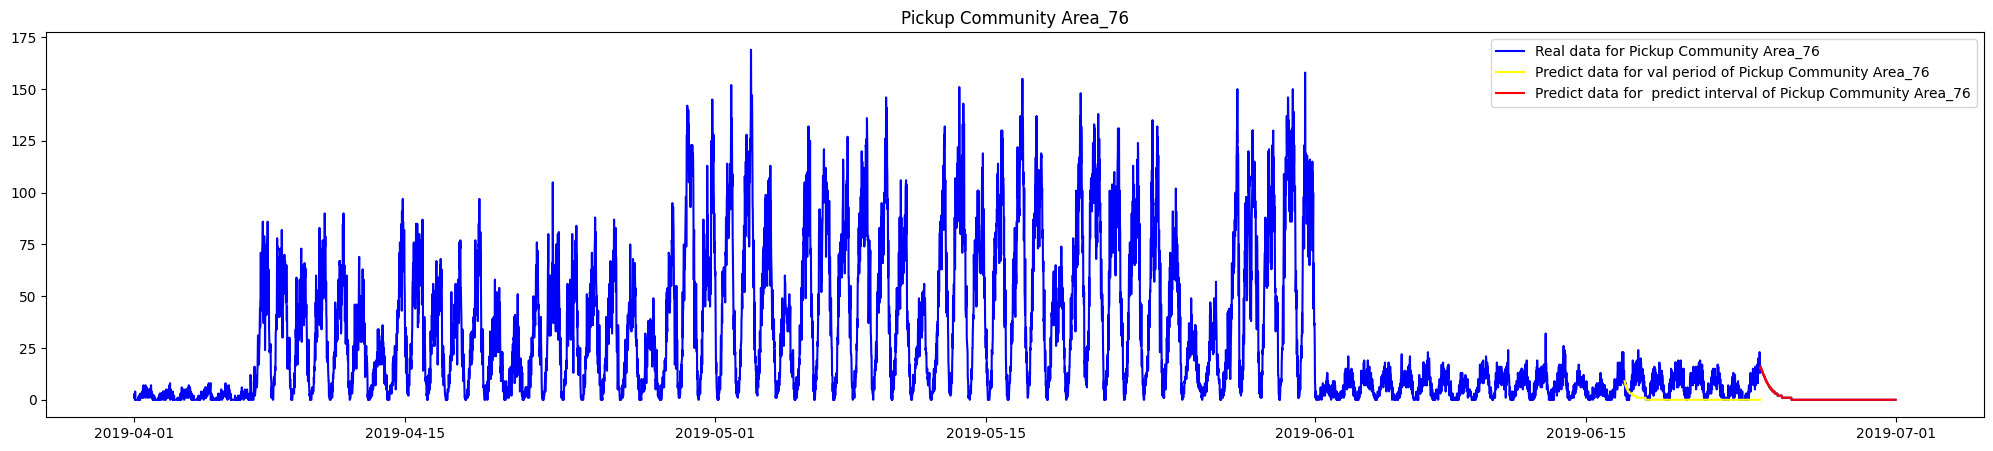

In [63]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_sarimax_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [64]:
df_sarimax_predict['Pickup Community Area_76']

Trip Start Timestamp
2019-06-24 00:00:00    15.0
2019-06-24 00:15:00    16.0
2019-06-24 00:30:00    16.0
2019-06-24 00:45:00    15.0
2019-06-24 01:00:00    15.0
                       ... 
2019-06-30 22:45:00     0.0
2019-06-30 23:00:00     0.0
2019-06-30 23:15:00     0.0
2019-06-30 23:30:00     0.0
2019-06-30 23:45:00     0.0
Name: Pickup Community Area_76, Length: 672, dtype: float64

In [65]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.907165750915751

In [66]:
df_results.loc[ len(df_results.index )] = ['SARIMA', round(res_mae, 2)]

In [67]:
# from pandas import Series
# from statsmodels.tsa.stattools import adfuller
#
#
# def adfuller_test(series, signif=0.05):
#
# 	"""
# 	Perform Augmented Dickey-Fuller to test for Stationarity of the given series
# 	and print report. Null Hypothesis: Data has unit root and is non-stationary.
#
# 	series: time series in pd.Series format
# 	signif: significance level for P-value to reject Null Hypothesis
# 	"""
# 	x = adfuller(series, autolag='AIC')
#
# 	#using dictionary saves different data types (float, int, boolean)
# 	output = {'Test Statistic': x[0],
# 			  'P-value': x[1],
# 			  'Number of lags': x[2],
# 			  'Number of observations': x[3],
# 			  f'Reject (signif. level {signif})': x[1] < signif }
#
# 	for key, val in x[4].items():
# 		output[f'Critical value {key}'] = val
#
# 	return Series(output)


In [68]:
# res = df_train.apply(lambda x: adfuller_test(x, 0.05), axis=0)

In [69]:
# print(res['Pickup Community Area_76'])

In [70]:
# from statsmodels.tsa.stattools import adfuller
# import pandas as pd
# import numpy as np
# %matplotlib inline
#
# series = np.random.randn(100)
# result = adfuller(series, autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
# 	print('Critial Values:')
# 	print(f'   {key}, {value}')

In [71]:
# import statsmodels.api as sm
#
# for area in df_train:
# 	p = sm.tsa.stattools.adfuller(df_train[area])[1]
# 	print(f'{area}: Критерий Дики-Фуллера (p-value) = {p}')

## Bonus

1. Try to use machine learning algorithms for time series analysis. Make a prediction for each area for the next 673 intervals.
2. Try to use deep learning algorithms for time series analysis. Make a prediction for each area for the next 673 intervals.
3. Try to achieve an even better average MAE on the test dataset – 8.0.

---

1. Для анализа временных рядов используйте алгоритмы машинного обучения. Сделайте с их помощью прогноз для каждого района по всем  673 временным интервалам.
2. Для анализа временных рядов используйте алгоритмы глубокого обучения. Сделайте с их помощью прогноз для каждого района по всем  673 временным интервалам.
3. Постарайтесь достичь среднего значения MAE, равного не более 8,0 на тестовом наборе данных.

### ML
1. Для анализа временных рядов используйте алгоритмы машинного обучения. Сделайте с их помощью прогноз для каждого района по всем  673 временным интервалам.



In [72]:
df_ml = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_ml.fillna(0.0, inplace=True)

In [73]:
df_total = df.copy()
df_total = df_total.append(df_ml)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/237251531.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_ml)


In [74]:
df_val_predict = df_val.copy() * 0.0
df_val_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
lags_list = [672, 1344, 2017]

# for area in df_total[df.columns[76:77]]:
for area in df_total:
	model_lr = LinearRegression()
	X_train, X_test, y_train, y_test, X_predict = prepare_data(df_total[area], lags_list)
	model_lr.fit(X_train, y_train)

	df_val_predict[area] = model_lr.predict(X_test)
	df_ml[area] = model_lr.predict(X_predict)
	# y_val = y_val_predict.copy()
	# y_val[y_val_predict < 0] = 0

In [76]:
df_ml = update_df(df_ml)
df_val_predict = update_df(df_val_predict)

In [77]:
df_val_predict.tail(70)

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 06:30:00,5.0,1.0,1.0,2.0,1.0,0.0,6.0,3.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0
2019-06-23 06:45:00,7.0,1.0,1.0,2.0,1.0,1.0,7.0,2.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
2019-06-23 07:00:00,7.0,1.0,1.0,1.0,1.0,0.0,6.0,2.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0
2019-06-23 07:15:00,7.0,1.0,1.0,1.0,1.0,0.0,6.0,2.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
2019-06-23 07:30:00,7.0,1.0,1.0,1.0,1.0,0.0,6.0,3.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-23 22:45:00,10.0,1.0,1.0,1.0,1.0,0.0,8.0,2.0,33.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1.0
2019-06-23 23:00:00,8.0,1.0,1.0,2.0,1.0,0.0,7.0,3.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0
2019-06-23 23:15:00,9.0,1.0,1.0,2.0,1.0,0.0,7.0,3.0,27.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,2.0


In [78]:
df_total = df.copy()
df_total = df_total.append(df_ml)
df_total.tail(700)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/2683587798.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_ml)


,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 17:00:00,7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-23 17:15:00,1.0,2.0,1.0,1.0,1.0,0.0,9.0,2.0,14.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0
2019-06-23 17:30:00,6.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,13.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0
2019-06-23 17:45:00,6.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
2019-06-23 18:00:00,10.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 22:45:00,7.0,1.0,1.0,2.0,1.0,0.0,5.0,3.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0
2019-06-30 23:00:00,6.0,1.0,1.0,2.0,1.0,0.0,7.0,2.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1.0
2019-06-30 23:15:00,9.0,1.0,1.0,1.0,1.0,0.0,7.0,2.0,35.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,1.0


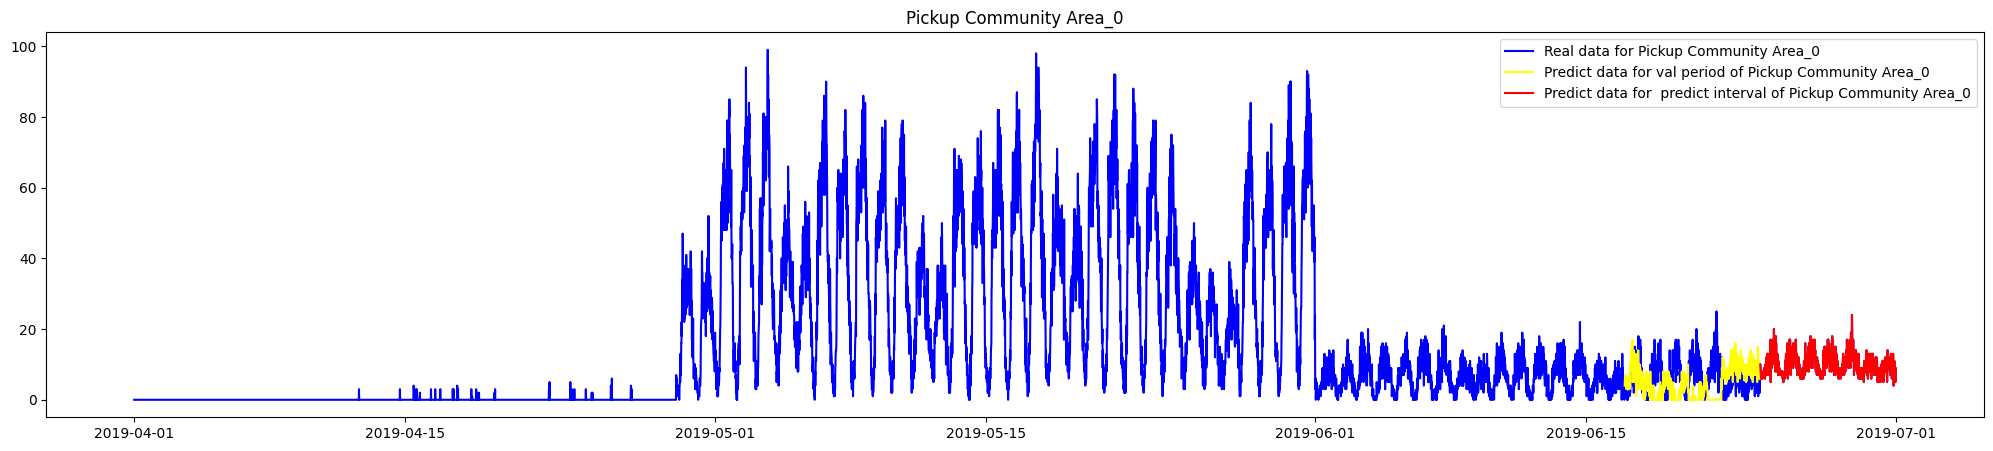

In [79]:
for area in df_total[df_total.columns[:1]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_ml[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [80]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

1.0847069597069599

In [81]:
df_results.loc[ len(df_results.index )] = ['ML (Linear Regression)', round(res_mae, 2)]

## DS algorithm

2. Для анализа временных рядов используйте алгоритмы глубокого обучения. Сделайте с их помощью прогноз для каждого района по всем  673 временным интервалам.

In [82]:
df_ds = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_ds.fillna(0.0, inplace=True)

In [83]:
df_total = df.copy()
df_total = df_total.append(df_ds)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/141623409.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_ds)


In [84]:
df_val_predict = df_val.copy() * 0.0
df_val_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
	# Define the LSTM model
	model_ds = Sequential()
	model_ds.add(LSTM(672, activation='relu', input_shape=(1, 3, 1)))
	model_ds.add(Dropout(0.3))
	# model.add(LSTM(256))
	# model.add(Dropout(0.5))
	model_ds.add(Dense(1))
	model_ds.add(Activation("relu"))
	model_ds.compile(loss="mae", optimizer="adam")
	model_ds.build(input_shape=(1, 3, 1))
	model_ds.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (1, 672)                 1811712   
 er)                                                             
                                                                 
 dropout (Dropout)           (1, 672)                  0         
                                                                 
 dense (Dense)               (1, 1)                    673       
                                                                 
 activation (Activation)     (1, 1)                    0         
                                                                 
Total params: 1,812,385
Trainable params: 1,812,385
Non-trainable params: 0
_________________________________________________________________


In [86]:
lags_list = [672, 1344, 2017]

for area in df_total:
	model_lr = LinearRegression()
	X_train, X_test, y_train, y_test, X_predict = prepare_data(df_total[area], lags_list)

	X_train = X_train.values
	X_test = X_test.values
	X_predict = X_predict.values

	X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
	X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
	X_predict = X_predict.reshape(X_predict.shape[0], X_predict.shape[1], 1)

	model_ds.fit(X_train, y_train, batch_size=672, epochs=5, validation_split= 1 / 11)

	df_val_predict[area] = model_ds.predict(X_test)
	df_ds[area] = model_ds.predict(X_predict)

Epoch 1/5
10/10 [==============================] - 4s 210ms/step - loss: 14.2999 - val_loss: 6.2142
Epoch 2/5
10/10 [==============================] - 2s 186ms/step - loss: 10.3073 - val_loss: 5.7293
Epoch 3/5
10/10 [==============================] - 2s 195ms/step - loss: 9.5256 - val_loss: 5.3541
Epoch 4/5
10/10 [==============================] - 2s 189ms/step - loss: 9.1874 - val_loss: 4.8506
Epoch 5/5
21/21 [==============================] - 0s 10ms/step
Epoch 1/5
10/10 [==============================] - 2s 198ms/step - loss: 1.0701 - val_loss: 0.4736
Epoch 2/5
10/10 [==============================] - 2s 197ms/step - loss: 1.0649 - val_loss: 0.4855
Epoch 3/5
10/10 [==============================] - 2s 194ms/step - loss: 1.0587 - val_loss: 0.5012
Epoch 4/5
10/10 [==============================] - 2s 196ms/step - loss: 1.0540 - val_loss: 0.5047
Epoch 5/5
21/21 [==============================] - 0s 10ms/step
Epoch 1/5
10/10 [==============================] - 2s 178ms/step - loss: 1.029

In [87]:
df_ds = update_df(df_ds)
df_val_predict = update_df(df_val_predict)

In [88]:
df_total = df.copy()
df_total = df_total.append(df_ds)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_42608/141623409.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_ds)


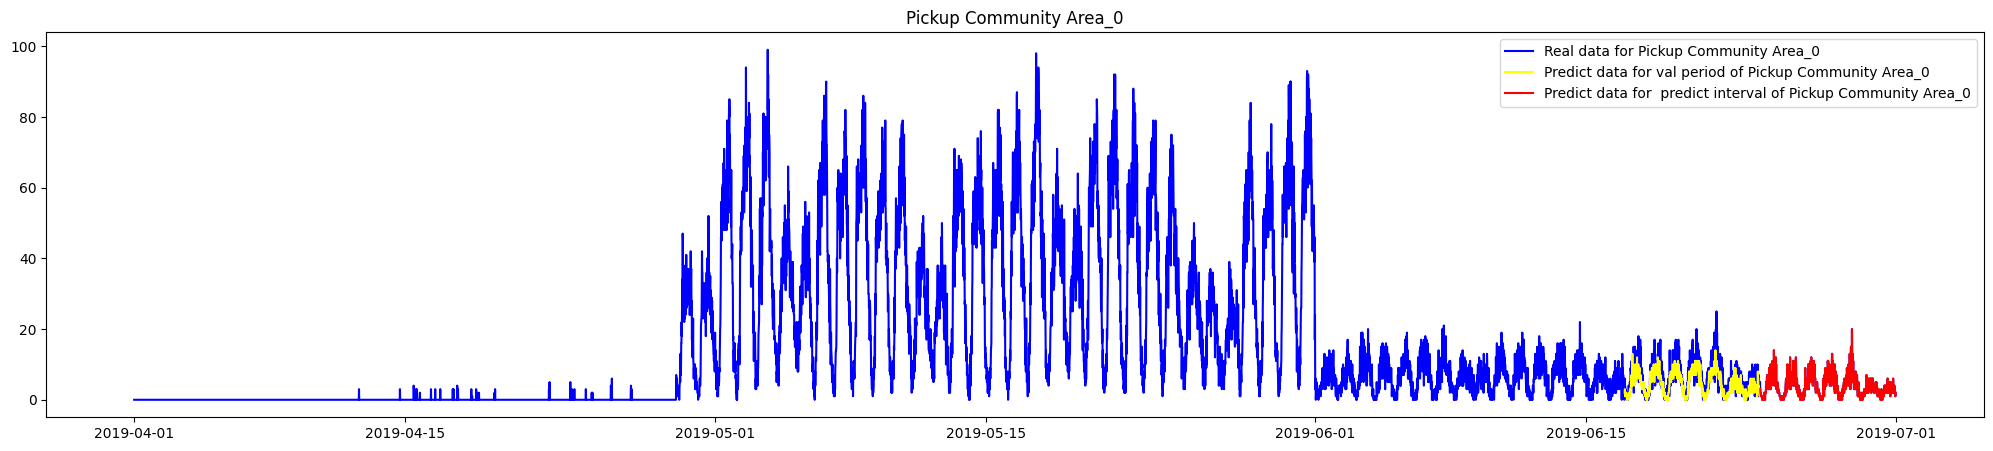

In [89]:
for area in df_total[df_total.columns[:1]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_ds[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [90]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.4989316239316239

In [91]:
df_results.loc[ len(df_results.index )] = ['DS (Long Short-Term Memory)', round(res_mae, 2)]

In [92]:
df_results.sort_values(by='MAE')

,Model_name,MAE
1,* Moving averages with window 2,0.20
2,* Moving averages with window 4,0.27
11,DS (Long Short-Term Memory),0.50
3,* Moving averages with window 96,0.63
4,Moving averages with window 672,0.65
6,Simple Exponential Smoothing (Braun),0.72
8,Exponential Smoothing (Holt-Winters),0.77
7,Exponential Smoothing (Holt),0.86
9,SARIMA,0.91
10,ML (Linear Regression),1.08


In [94]:
df_ds.to_csv('data/best_taxi_submission_file.csv')